# Config

### Imports

In [1]:
import itertools
import os
import random
import shutil
import time
from tqdm import tqdm
import uuid
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Constants

In [3]:
TRAIN_ON_TF = 'TF_2'
TRAIN_PROBE = 'A'
TEST_PROBE = 'B'
MOTIF_LEN = 32
NUM_MOTIF_DETECTORS=16
BATCH_SIZE = 64

In [4]:
DNA_BASES = 'ACGT'
RNA_BASES = 'ACGU'

In [5]:
PBM_DATA = "./data/dream5/pbm"

### Make training deterministic

In [6]:
def set_global_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
set_global_seed(42)

# Data preparation

### Read DREAM5 sequence data with binding scores

In [8]:
df_seq = pd.read_csv(f"{PBM_DATA}/sequences.tsv", sep='\t')
df_seq.head()

,Fold ID,Event ID,seq
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT


In [9]:
df_targets = pd.read_csv(f"{PBM_DATA}/targets.tsv", sep='\t')
df_targets.head()

,TF_40,TF_41,TF_42,TF_43,TF_44,TF_45,TF_46,TF_47,TF_48,TF_49,...,C_19,C_18,C_15,C_14,C_17,C_16,C_11,C_10,C_13,C_12
0,823.914118,12702.625538,2124.023125,2314.305782,1474.888697,1131.785521,4597.003319,14589.890994,1556.951404,34180.775942,...,1651.254953,1242.303363,724.105850,3184.883349,8935.394363,12689.558779,4102.312624,505.126184,12946.381724,1313.790253
1,1307.840222,4316.426121,2554.658908,3415.320661,3408.586803,1697.342725,5272.763446,22903.130555,2181.551097,10000.297243,...,3505.604759,2516.000120,1640.114829,3463.713253,19535.468264,18006.721690,6890.427794,1402.597000,38309.856355,3024.107809
2,1188.353499,3436.803941,2088.909658,3708.324021,2219.741833,1571.646567,6225.376501,13858.014077,1971.053716,18800.025304,...,3270.572883,1693.419147,997.792996,3196.992198,16695.027604,14486.992627,13517.968701,10680.866586,25648.825592,2675.530918
3,1806.103795,6531.268855,2406.186212,3601.204703,2828.415329,2746.861783,5810.104650,25701.749693,2191.273065,19213.880658,...,2701.555739,2059.614815,1432.163042,4927.163643,18896.765835,18784.043322,8608.167421,4624.044391,23651.726053,3679.449867
4,1417.411525,3951.243575,2581.309532,3375.884699,2764.716964,1806.919566,5033.976283,26364.859152,2311.790793,16139.097553,...,2457.214141,1901.709222,1672.531034,3877.787322,14699.253953,17119.871513,8995.328144,12641.425965,27999.405431,3128.844808


### Build a dataframe for single transcription factor

In [10]:
def build_df(tf, df_seq, df_targets):
    df = df_seq.copy()
    df["Target"] = df_targets[tf].values
    return df

In [11]:
df = build_df(TRAIN_ON_TF, df_seq, df_targets)
df.head()

,Fold ID,Event ID,seq,Target
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598


### Remove probe specific biases for each sequence

In [12]:
biases = df_targets.median(axis=1).values
biases

array([2641.988164 , 4170.2475   , 3699.8877625, ..., 2287.3149815,
       1884.915039 , 1231.9427485], shape=(80856,))

In [13]:
# Note this won't cause data leak because then normalization is sequence specific and does not use other sequences
df['TargetNorm'] = df['Target'].values / biases
df.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


### Calculate NA content and drop rows

In [14]:
# Only 4% NA content, it is safe to drop the rows
df['Target'].isna().mean()

np.float64(0.04049173839912932)

In [15]:
df.dropna(subset=['Target'], inplace=True)
df['Target'].isna().mean()

np.float64(0.0)

### Train/Test data split

In [16]:
df_train = df[df['Fold ID'] == TRAIN_PROBE]
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426


In [17]:
df_test = df[df['Fold ID'] == TEST_PROBE]
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


In [18]:
df_train.shape, df_test.shape

((38041, 5), (39541, 5))

### Add labels for ROC and AUC

In [19]:
# DREAM5 https://pmc.ncbi.nlm.nih.gov/articles/PMC3687085/
def add_label(d):
    # Add positive label to only rows with binding score higher than mean + 4*std
    mean = d['Target'].mean()
    std = d['Target'].std()
    lower_limit = mean + 4*std

    # Limits MAX: 1300 rows MIN: 50 rows
    top = d[d['Target'] > lower_limit].copy()
    if len(top) >= 50:
        top = top.sort_values(by='Target', ascending=False).head(1300)
    else:
        top = d.sort_values(by='Target', ascending=False, inplace=False).head(50)

    d['Label'] = 0
    d.loc[top.index, 'Label'] = 1

In [20]:
add_label(df_train)
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724,0
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000,0
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750,0
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457,0
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426,0


In [21]:
df_train[df_train['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40545,A,HK37117,ATAGATGATTGCCTAATAGAACCTACACAGTAAACCCTGT,23505.012865,6.751061,1
40630,A,HK39222,AGGTGTTACATATATCAGCTTGGGTGGATACCCGACCTGT,19403.494948,7.323275,1
40751,A,HK31683,GGCATTCAGGACAATTAGATAACCCAAGCGTAGCCCCTGT,20245.802138,8.385751,1
40775,A,HK34305,TGTATTGCATAAACGTTCCAGGACCCCTGGCTCACCCTGT,33224.921774,14.948550,1
40961,A,HK15380,TGTATGATCACCAACTCATGGTTGCGCAATGAACCCCTGT,22591.018693,7.530934,1


In [22]:
add_label(df_test)
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377,0
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671,0
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141,0
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181,0
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512,0


In [23]:
df_test[df_test['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
149,B,MEforward05359,TAAGAAAAGATTTTTACGTAACATGTCTACTCTGGCCTGT,54999.072022,15.626592,1
598,B,MEreverse19582,ATCGAGTCGGCTTTACAATTACATAATCTAAGCTACCTGT,72179.964196,10.621469,1
640,B,MEforward05965,AGCTACATGTAGCTCGGCATTTATATAACCCACTGCCTGT,26433.473625,5.848461,1
769,B,MEreverse06558,ATTCTAACGACTGTGACATAATGACCCCACCTCGGCCTGT,28221.317418,5.393725,1
825,B,MEreverse08764,TACGCATTTACGTTGCATAATCTTGTGAGTAGCAGCCTGT,54040.187164,10.802248,1


### Mathmatical target normalization to N(0, 1)

In [24]:
# target_norm = df_train['TargetNorm'].values
# df_train['TargetNormFinal'] = (target_norm - target_norm.mean()) / target_norm.std()
# df_train.head()

In [25]:
# target_norm = df_test['TargetNorm'].values
# df_test['TargetNormFinal'] = (target_norm - target_norm.mean()) / target_norm.std()
# df_test.head()

### DNA/RNA sequence to Matrix logic

In [26]:
def fill_cell(motif_len, row, col, bases, seq):
    num_rows = len(seq) + 2 * motif_len - 2
    
    # First M-1 rows are filled with 0.25
    if row < motif_len-1:
        return 0.25

    # Last M-1 rows are filled with 0.25
    if num_rows-1-row < motif_len-1:
        return 0.25

    idx = row - motif_len + 1
    if seq[idx] == bases[col]:
        return 1.0

    return 0.0

def seq2matrix(seq, motif_len, typ='DNA'):
    bases = DNA_BASES if typ == 'DNA' else RNA_BASES
    num_rows = len(seq) + 2 * motif_len - 2
    result = np.empty([num_rows, 4])
    for row in range(num_rows):
        for col in range(4):
            result[row, col] = fill_cell(motif_len, row, col, bases, seq)
    return np.transpose(result)

In [27]:
# Test the function
S = seq2matrix("ATGG", 3, 'DNA')
S

array([[0.25, 0.25, 1.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 1.  , 1.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 1.  , 0.  , 0.  , 0.25, 0.25]])

In [28]:
S.shape

(4, 8)

### Train Data Augmentation (Reverse Complement)

In [29]:
def reverse_complement_batch(x):
    # x: (B, 4, L)
    # reverse the sequence
    x = torch.flip(x, dims=[2])
    
    # swap A-T, C-G
    # A C G T → T G C A
    x = x[:, [3, 2, 1, 0], :]

    return x

def reverse_complement_M(x):
    # x: (4, L)
    # reverse the sequence
    x = torch.flip(x, dims=[1])
    
    # swap A-T, C-G
    # A C G T → T G C A
    x = x[[3, 2, 1, 0], :]

    return x

### Sequence Dataset and Loader

In [30]:
class SeqDataset(Dataset):
    def __init__(self, df, augment=False):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values
        self.aug = augment

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        
        M = seq2matrix(seq, MOTIF_LEN, 'DNA')
        
        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        # Augment the data
        if self.aug and random.random() > 0.5:
            x = reverse_complement_M(x)
        
        return x, y, label

In [31]:
train_dataset = SeqDataset(df_train, augment=True)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [32]:
xs, ys, labels = [], [], []

for x, y, label in train_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_train = torch.stack(xs)
y_train = torch.tensor(ys, dtype=torch.float32)
label_train = torch.tensor(labels)

In [33]:
x, target, label = next(iter(train_loader))
x.shape, target.shape, label.shape

(torch.Size([64, 4, 102]), torch.Size([64]), torch.Size([64]))

In [34]:
x

tensor([[[0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500]],

        ...,

        [[0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
     

In [35]:
# Do NOT augment test dataset
test_dataset = SeqDataset(df_test, augment=False)

xs, ys, labels = [], [], []

for x, y, label in test_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_test = torch.stack(xs)
y_test = torch.tensor(ys, dtype=torch.float32)
label_test = torch.tensor(labels)

In [36]:
x_test.shape, y_test.shape, label_test.shape

(torch.Size([39541, 4, 102]), torch.Size([39541]), torch.Size([39541]))

## Augmentation

In [37]:
# Simulate that motifs can be slightly misaligned by randomly shifting the sequence left or right by a few bases
def random_shift(x, max_shift=3):
    shift = random.randint(-max_shift, max_shift)
    if shift == 0:
        return x
    
    x = torch.roll(x, shifts=shift, dims=1)
    
    if shift > 0:
        x[:, :shift] = 0.25
    else:
        x[:, shift:] = 0.25
    return x

In [38]:
# Create a sample tensor
sample_tensor = torch.tensor([
    [0.25, 0.25, 0.25, 0.25, 1.0, 0.0, 0.0, 0.0],
    [0.25, 0.25, 0.25, 0.25, 0.0, 1.0, 0.0, 0.0],
    [0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 1.0, 0.0],
    [0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 1.0]
], dtype=torch.float32)

# Apply random shift
shifted_tensor = random_shift(sample_tensor, max_shift=3)

# Print original and shifted tensors
print("Original Tensor:")
print(sample_tensor)

print("\nShifted Tensor:")
print(shifted_tensor)

Original Tensor:
tensor([[0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 1.0000]])

Shifted Tensor:
tensor([[0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.0000]])


In [39]:
# Adding noise to simulate sequencing uncertainty (which can also do some regularization)
def add_gaussian_noise(x, noise_std=0.01):
    noise = torch.randn_like(x) * noise_std
    x_noisy = x + noise

    # Ensure no negative values (clamp to minimum of 0)
    x_noisy = torch.clamp(x_noisy, min=0.0)

    # Renormalize each column so that the sum of probabilities is 1
    x_noisy = x_noisy / x_noisy.sum(dim=0, keepdim=True)

    return x_noisy

In [40]:
# Test the add_gaussian_noise function
sample_tensor = torch.tensor([
    [0.25, 0.25, 0.25, 0.25],
    [0.25, 0.25, 0.25, 0.25],
    [0.25, 0.25, 0.25, 0.25],
    [0.25, 0.25, 0.25, 0.25]
], dtype=torch.float32)

# Apply Gaussian noise
noisy_tensor = add_gaussian_noise(sample_tensor, noise_std=0.01)

# Print original and noisy tensors
print("Original Tensor:")
print(sample_tensor)

print("\nNoisy Tensor:")
print(noisy_tensor)

# Check if the noisy tensor is still normalized
print("\nColumn sums (should be close to 1):")
print(noisy_tensor.sum(dim=0))

Original Tensor:
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]])

Noisy Tensor:
tensor([[0.2598, 0.2394, 0.2563, 0.2438],
        [0.2503, 0.2446, 0.2674, 0.2515],
        [0.2468, 0.2467, 0.2423, 0.2507],
        [0.2430, 0.2693, 0.2339, 0.2540]])

Column sums (should be close to 1):
tensor([1.0000, 1.0000, 1.0000, 1.0000])


In [41]:
# Point mutations/SNPs with low probability
def random_mutation(x, motif_length=MOTIF_LEN, mutation_rate=0.005):
    x = x.clone()
     
    for i in range(motif_length-1, x.shape[1]-motif_length+1):
        if random.random() < mutation_rate:
            current_base = torch.argmax(x[:, i]).item()
            new_base = random.choice([j for j in range(4) if j != current_base])

            x[:, i] = 0.0
            x[new_base, i] = 1.0
    
    return x

In [42]:
# Test the random_mutation function
test_tensor = torch.tensor([
    [0.25, 0.25, 1.0, 0.0, 0.0, 0.0, 0.25, 0.25],
    [0.25, 0.25, 0.0, 1.0, 0.0, 0.0, 0.25, 0.25],
    [0.25, 0.25, 0.0, 0.0, 1.0, 0.0, 0.25, 0.25],
    [0.25, 0.25, 0.0, 0.0, 0.0, 1.0, 0.25, 0.25]
], dtype=torch.float32)

# Apply random mutation
mutated_tensor = random_mutation(test_tensor, motif_length=3, mutation_rate=0.5)

# Print original and mutated tensors
print("Original Tensor:")
print(test_tensor)

print("\nMutated Tensor:")
print(mutated_tensor)

Original Tensor:
tensor([[0.2500, 0.2500, 1.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 1.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 1.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 1.0000, 0.2500, 0.2500]])

Mutated Tensor:
tensor([[0.2500, 0.2500, 0.0000, 1.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 1.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 1.0000, 1.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500]])


In [43]:
class SeqDatasetAugmented(Dataset):
    def __init__(self, df, 
                 shift=0,
                 noise_std=0.0,
                 mutation_rate=0.0):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values
        self.shift = shift
        self.noise_std = noise_std
        self.mutation_rate = mutation_rate

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        M = seq2matrix(seq, MOTIF_LEN, 'DNA')
        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        if self.mutation_rate > 0.0:
            x = random_mutation(x, motif_length=MOTIF_LEN, mutation_rate=self.mutation_rate)

        if self.shift > 0:
            x = random_shift(x, max_shift=self.shift)
            
        if self.noise_std > 0.0:
            x = add_gaussian_noise(x, noise_std=self.noise_std)

        return x, y, label

In [44]:
train_aug_dataset = SeqDatasetAugmented(df_train, shift=3, noise_std=0.01, mutation_rate=0.005)
train_aug_loader = DataLoader(
    train_aug_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [45]:
x, target, label = next(iter(train_aug_loader))
x.shape, target.shape, label.shape

(torch.Size([64, 4, 102]), torch.Size([64]), torch.Size([64]))

In [46]:
x

tensor([[[0.2418, 0.2608, 0.2571,  ..., 0.2624, 0.2538, 0.2425],
         [0.2594, 0.2467, 0.2600,  ..., 0.2518, 0.2538, 0.2664],
         [0.2495, 0.2417, 0.2383,  ..., 0.2424, 0.2483, 0.2532],
         [0.2493, 0.2508, 0.2446,  ..., 0.2434, 0.2441, 0.2379]],

        [[0.2676, 0.2384, 0.2517,  ..., 0.2447, 0.2435, 0.2535],
         [0.2311, 0.2555, 0.2515,  ..., 0.2527, 0.2585, 0.2609],
         [0.2489, 0.2471, 0.2415,  ..., 0.2646, 0.2542, 0.2533],
         [0.2525, 0.2590, 0.2554,  ..., 0.2380, 0.2438, 0.2323]],

        [[0.2427, 0.2438, 0.2582,  ..., 0.2461, 0.2541, 0.2638],
         [0.2515, 0.2631, 0.2460,  ..., 0.2437, 0.2405, 0.2336],
         [0.2388, 0.2309, 0.2591,  ..., 0.2641, 0.2483, 0.2497],
         [0.2670, 0.2621, 0.2368,  ..., 0.2461, 0.2570, 0.2529]],

        ...,

        [[0.2547, 0.2368, 0.2453,  ..., 0.2565, 0.2634, 0.2522],
         [0.2489, 0.2554, 0.2513,  ..., 0.2475, 0.2371, 0.2475],
         [0.2435, 0.2546, 0.2366,  ..., 0.2568, 0.2502, 0.2540],
     

# Model

### DeepBind Model

In [47]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DeepBindShallow(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.5):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc1 = nn.Linear(num_motif_detectors, 1)
        
        self.init_weights()

    def init_weights(self):
        init.normal_(self.conv.weight, mean=0.0, std=0.001)
        init.constant_(self.conv.bias, 0.0)

        init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        init.constant_(self.fc1.bias, 0.0)
        
    def forward_pass(self, x):
        
        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc1(x)

        return x

    def forward(self, x):
        r = self.forward_pass(x)
        
        x_comp = reverse_complement_batch(x)
        r_comp = self.forward_pass(x_comp)
        
        r_final = torch.max(r, r_comp)
        
        return r_final

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DeepBind(nn.Module):
    def __init__(self, 
                 num_motif_detectors, 
                 motif_len,
                 dropout,
                 conv_init_w,
                 fc_init_w):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc1 = nn.Linear(num_motif_detectors, 32)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(32, 1)

        self.init_weights(conv_init_w, fc_init_w)

    def init_weights(self, conv_init_w, fc_init_w):
        init.normal_(self.conv.weight, mean=0.0, std=conv_init_w)
        init.constant_(self.conv.bias, 0.0)

        init.normal_(self.fc1.weight, mean=0.0, std=fc_init_w)
        init.constant_(self.fc1.bias, 0.0)
        
        init.normal_(self.fc2.weight, mean=0.0, std=fc_init_w)
        init.constant_(self.fc2.bias, 0.0)

    def forward_pass(self, x):
        
        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def forward(self, x):
        r = self.forward_pass(x)
        
        x_comp = reverse_complement_batch(x)
        r_comp = self.forward_pass(x_comp)
        
        r_final = torch.max(r, r_comp)
        
        return r_final

### Model Wrapper for training

In [49]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class ModelWrapper:
    def __init__(self, m, lr=1e-3, w_decay=1e-3):
        self.model = m.to(DEVICE)
        #self.opt = torch.optim.Adam(self.model.parameters(), lr=0.0005)
        self.opt = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=w_decay)
        self.criterion = torch.nn.MSELoss()

    def train_step(self, x, target):
        self.model.train()
        
        x = x.to(DEVICE)
        target = target.to(DEVICE)

        self.opt.zero_grad()

        pred = self.model(x)
        loss = self.criterion(pred.squeeze(), target)

        loss.backward()
        self.opt.step()
        
        return loss.item()

    def predict(self, x):
        self.model.eval()
        x = x.to(DEVICE)
        pred = self.model(x).squeeze()
        pred = pred.detach().cpu().numpy()
        return pred

    def evaluate(self, x, y_true, label_true):
        y_pred = self.predict(x)

        fpr, tpr, thresholds = roc_curve(label_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        pearson_corr, _ = pearsonr(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)

        # plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        # plt.plot([0, 1], [0, 1], linestyle='--')
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.legend()
        # plt.show()

        return {
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'auc': roc_auc,
        }

    def train_one_epoch(self, loader):
        epoch_loss = 0
        for i, (x, y, label) in enumerate(tqdm(loader)):
            epoch_loss += self.train_step(x, y)
        epoch_loss = epoch_loss / len(loader)
        return epoch_loss

### Sanity Check: Overfit on single mini-batch

In [50]:
x, y, label = next(iter(train_loader))
x.shape, y.shape, label.shape

(torch.Size([64, 4, 102]), torch.Size([64]), torch.Size([64]))

In [51]:
m_sanity = DeepBindShallow(num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN)

In [52]:
mw_sanity = ModelWrapper(m_sanity)

In [53]:
for i in range(10000):
    loss = mw_sanity.train_step(x, y)
    if i % 1000 == 0:
        print(loss)

1.459786057472229
1.0523425464370462e-09
2.3572774288105336e-10
7.808413637899747e-11
2.7079366526905346e-11
9.847178628064057e-12
3.773703571852138e-12
1.3457512881842604e-11
2.787922670499654e-12
1.2035650254205166e-12


In [53]:
pred_sanity = mw_sanity.predict(x)
pred_sanity[:10]

array([2.2234055e-04, 6.1477826e-05, 1.5251474e-04, 1.9704390e-04,
       9.0972608e-05, 8.1082631e-05, 7.0786991e-05, 9.5585878e-05,
       5.7998532e-05, 3.6488178e-05], dtype=float32)

In [54]:
target_sanity = y.cpu().numpy()
target_sanity[:10]

array([0.71372354, 1.        , 0.7907503 , 0.6224574 , 0.6264257 ,
       0.89628714, 1.0121148 , 0.7338479 , 0.7446303 , 0.61046606],
      dtype=float32)

In [55]:
for name, p in mw_sanity.model.named_parameters():
    print(name, p.data.abs().mean().item())

conv.weight 0.0008123329607769847
conv.bias 0.0
fc1.weight 0.007294829934835434
fc1.bias 0.0


### Sanity Check: Reverse compliment

In [56]:
np.allclose(mw_sanity.predict(x), mw_sanity.predict(reverse_complement_batch(reverse_complement_batch(x))))

True

# Training

In [57]:
import os

def save_snapshot(mw, epoch, params):
    snap_path = "/tmp/snaps"
    os.makedirs(snap_path, exist_ok=True)
    name = f"{snap_path}/model_epoch_{epoch}.pt"
    torch.save({
        "model": mw.model.state_dict(),
        "params": params,
    }, name)
    return name

def load_snapshot(path):
    ckpt = torch.load(path, map_location="cpu")
    params = ckpt["params"]
    print(params)

    m = DeepBind(
        num_motif_detectors=params['num_motif_detectors'],
        motif_len=params['motif_len'],
        dropout=params['dropout'],
        conv_init_w=params['conv_init_weight_std'],
        fc_init_w=params['fc_init_weight_std'],
    )
    mw = ModelWrapper(m, lr=params['lr'], w_decay=params['weight_decay'])
    
    mw.model.load_state_dict(ckpt["model"])

    return mw

In [58]:
import wandb

def train_wandb(run_name, mw, loader, epochs, params):
    run = wandb.init(
        entity="vvaza22-free-university-of-tbilisi",
        project="CompBioFinal",
        name=run_name,
        config={
            "model": "DeepBind",
            "dataset": "DREAM5",
            "epochs": epochs,
            **params
        },
    )

    for epoch in range(1, epochs+1):
        print(f"===== EPOCH {epoch} =====")
        epoch_loss = mw.train_one_epoch(loader)
        print(f"Loss: {epoch_loss}")

        metrics_train = mw.evaluate(x_train, y_train, label_train)
        metrics_test = mw.evaluate(x_test, y_test, label_test)
        
        wandb.log({
            'epoch_loss': epoch_loss,
            'train/pearson': metrics_train['pearson'],
            'train/spearman': metrics_train['spearman'],
            'train/auc': metrics_train['auc'],
            'test/pearson': metrics_test['pearson'],
            'test/spearman': metrics_test['spearman'],
            'test/auc': metrics_test['auc']
        }, step=epoch)

    run.finish()

In [59]:
def get_for_eval(dataset):
    xs, ys, labels = [], [], []

    for x, y, label in dataset:
        xs.append(x)
        ys.append(y)
        labels.append(label)

    x_all = torch.stack(xs)
    y_all = torch.tensor(ys, dtype=torch.float32)
    label_all = torch.tensor(labels)

    return x_all, y_all, label_all

In [60]:
wandb.login()

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/cim/.netrc.
wandb: Currently logged in as: dachis (dachis-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [61]:
import wandb

MIN_DELTA = 1e-3

def early_stopping_train_wandb(run_name, mw, df_train, epochs, params):
    with wandb.init(
        entity="dachis-none",
        project="CompBioFinal",
        name=run_name,
        config={
            "model": "DeepBind",
            "dataset": "DREAM5",
            "epochs": epochs,
            "tf": TRAIN_ON_TF,
            **params
            }):
        
        train_aug_dataset = SeqDatasetAugmented(
            df_train,
            shift=params['shift'],
            noise_std=params['noise_std'],
            mutation_rate=params['mutation_rate'],
            )
        train_aug_loader = DataLoader(
            train_aug_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=False
            )

        x_train, y_train, label_train = get_for_eval(train_aug_dataset)
        x_test, y_test, label_test = get_for_eval(test_dataset)
        
        best_test_pearson = 0

        for epoch in range(1, epochs+1):
            epoch_loss = mw.train_one_epoch(train_aug_loader)

            metrics_train = mw.evaluate(x_train, y_train, label_train)
            metrics_test = mw.evaluate(x_test, y_test, label_test)

            results = {
                'epoch': epoch,
                'epoch_loss': epoch_loss,
                'train/pearson': metrics_train['pearson'],
                'train/spearman': metrics_train['spearman'],
                'train/auc': metrics_train['auc'],
                'test/pearson': metrics_test['pearson'],
                'test/spearman': metrics_test['spearman'],
                'test/auc': metrics_test['auc'],
                'diff/pearson': metrics_train['pearson'] - metrics_test['pearson'],
                'diff/spearman': metrics_train['spearman'] - metrics_test['spearman'],
                'diff/auc': metrics_train['auc'] - metrics_test['auc'],
            }
            print(results)

            # Snapshot the model
            # snap = save_snapshot(mw, epoch, params)
            # artifact = wandb.Artifact(
            #     name=f"model_epoch_{epoch}",
            #     type="model"
            # )
            # artifact.add_file(snap)
            # wandb.log_artifact(artifact)
        
            wandb.log(results, step=epoch)

            if metrics_test['pearson'] > best_test_pearson:
                best_test_pearson = metrics_test['pearson']
            elif metrics_test['pearson'] + MIN_DELTA < best_test_pearson:
                # Overfitting
                print(f"Early stopping on epoch {epoch}")
                break
    
        snap = save_snapshot(mw, 'final', params)
        artifact = wandb.Artifact(
            name=f"model_final",
            type="model"
        )
        artifact.add_file(snap)
        wandb.log_artifact(artifact)

In [ ]:
from sklearn.model_selection import ParameterGrid
from scipy.stats import loguniform

param_grid = {
    'lr': [0.0005],
    'dropout': [0.25],
    'num_motif_detectors': [16],
    'motif_len': [16],
    'weight_decay': [1e-4, 1e-5],
    'conv_init_weight_std': [1e-4, 1e-3],
    'fc_init_weight_std': [1e-3],
    # 'shift': [0, 3, 5, 10],
    # 'noise_std': [0, 0.01, 0.05, 0.1],
    # 'mutation_rate': [0, 0.001, 0.005, 0.01],
    'shift': [5],
    'noise_std': [0],
    'mutation_rate': [0.005],
}
print(param_grid)

grid = ParameterGrid(param_grid)

print(f"Total: {len(grid)}")

{'lr': [0.0005], 'dropout': [0.25], 'num_motif_detectors': [16], 'motif_len': [16], 'weight_decay': [0.0001, 1e-05], 'conv_init_weight_std': [0.0001, 0.001], 'fc_init_weight_std': [0.001], 'shift': [0, 3, 5, 10], 'noise_std': [0, 0.01, 0.05, 0.1], 'mutation_rate': [0, 0.001, 0.005, 0.01]}
Total: 256


In [63]:
run_id = 0
for params in grid:
    if run_id <= 122:
        run_id = run_id + 1
        continue
    print(f"Calibration with: {params}")

    run_name = f"{TRAIN_ON_TF}_Aug_data_{run_id}"
    
    m = DeepBind(
        num_motif_detectors=params['num_motif_detectors'],
        motif_len=params['motif_len'],
        dropout=params['dropout'],
        conv_init_w=params['conv_init_weight_std'],
        fc_init_w=params['fc_init_weight_std'],
    )
    mw = ModelWrapper(m, lr=params['lr'], w_decay=params['weight_decay'])

    early_stopping_train_wandb(run_name, mw, df_train, 30, params=params)

    run_id = run_id + 1

Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0.01, 'noise_std': 0.1, 'num_motif_detectors': 16, 'shift': 3, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:14<00:00, 39.90it/s]


{'epoch': 1, 'epoch_loss': 2.0963625253248614, 'train/pearson': np.float32(0.3236509), 'train/spearman': np.float64(0.36809279700845554), 'train/auc': 0.9860772084001809, 'test/pearson': np.float32(0.34390253), 'test/spearman': np.float64(0.2825735536070208), 'test/auc': 0.964369104814137, 'diff/pearson': np.float32(-0.020251632), 'diff/spearman': np.float64(0.08551924340143474), 'diff/auc': 0.021708103586043914}


100%|██████████| 595/595 [00:14<00:00, 40.89it/s]


{'epoch': 2, 'epoch_loss': 1.924902987868345, 'train/pearson': np.float32(0.33970463), 'train/spearman': np.float64(0.3602636925131596), 'train/auc': 0.9884271758926134, 'test/pearson': np.float32(0.3479248), 'test/spearman': np.float64(0.2758633284237478), 'test/auc': 0.9670530457200471, 'diff/pearson': np.float32(-0.008220166), 'diff/spearman': np.float64(0.08440036408941182), 'diff/auc': 0.021374130172566286}


100%|██████████| 595/595 [00:14<00:00, 39.84it/s]


{'epoch': 3, 'epoch_loss': 1.795113377880399, 'train/pearson': np.float32(0.408414), 'train/spearman': np.float64(0.34911275263835284), 'train/auc': 0.9885034027767837, 'test/pearson': np.float32(0.36864123), 'test/spearman': np.float64(0.26664758970297747), 'test/auc': 0.965589947439285, 'diff/pearson': np.float32(0.03977278), 'diff/spearman': np.float64(0.08246516293537537), 'diff/auc': 0.022913455337498778}


100%|██████████| 595/595 [00:14<00:00, 40.95it/s]


{'epoch': 4, 'epoch_loss': 1.6277060451377339, 'train/pearson': np.float32(0.5588332), 'train/spearman': np.float64(0.3512861920533376), 'train/auc': 0.9896281559339647, 'test/pearson': np.float32(0.42148426), 'test/spearman': np.float64(0.26881163475492414), 'test/auc': 0.9665334239992299, 'diff/pearson': np.float32(0.13734892), 'diff/spearman': np.float64(0.08247455729841346), 'diff/auc': 0.02309473193473477}


100%|██████████| 595/595 [00:14<00:00, 40.47it/s]


{'epoch': 5, 'epoch_loss': 1.4171486837898983, 'train/pearson': np.float32(0.6628425), 'train/spearman': np.float64(0.3491412824716999), 'train/auc': 0.9892196969401249, 'test/pearson': np.float32(0.4523819), 'test/spearman': np.float64(0.2712976385926787), 'test/auc': 0.9671589940034628, 'diff/pearson': np.float32(0.2104606), 'diff/spearman': np.float64(0.07784364387902121), 'diff/auc': 0.02206070293666207}


100%|██████████| 595/595 [00:14<00:00, 40.75it/s]


{'epoch': 6, 'epoch_loss': 1.204275410134001, 'train/pearson': np.float32(0.71307224), 'train/spearman': np.float64(0.3320977522015747), 'train/auc': 0.9878870818527102, 'test/pearson': np.float32(0.47134084), 'test/spearman': np.float64(0.26346739615092457), 'test/auc': 0.96643555913173, 'diff/pearson': np.float32(0.2417314), 'diff/spearman': np.float64(0.06863035605065015), 'diff/auc': 0.021451522720980276}


100%|██████████| 595/595 [00:15<00:00, 39.59it/s]


{'epoch': 7, 'epoch_loss': 1.0626276086108024, 'train/pearson': np.float32(0.74775416), 'train/spearman': np.float64(0.32520551510760487), 'train/auc': 0.9873735533698789, 'test/pearson': np.float32(0.4925229), 'test/spearman': np.float64(0.25444616844130763), 'test/auc': 0.9663974251543562, 'diff/pearson': np.float32(0.25523126), 'diff/spearman': np.float64(0.07075934666629724), 'diff/auc': 0.020976128215522638}


100%|██████████| 595/595 [00:14<00:00, 40.15it/s]


{'epoch': 8, 'epoch_loss': 1.0114416317466428, 'train/pearson': np.float32(0.7615842), 'train/spearman': np.float64(0.3281088091652429), 'train/auc': 0.9877919880014764, 'test/pearson': np.float32(0.49976525), 'test/spearman': np.float64(0.2539865013603503), 'test/auc': 0.9652225531006379, 'diff/pearson': np.float32(0.26181898), 'diff/spearman': np.float64(0.0741223078048926), 'diff/auc': 0.022569434900838514}


100%|██████████| 595/595 [00:14<00:00, 40.51it/s]


{'epoch': 9, 'epoch_loss': 0.9315075587324736, 'train/pearson': np.float32(0.7737892), 'train/spearman': np.float64(0.33537116340534645), 'train/auc': 0.987537067084429, 'test/pearson': np.float32(0.50747746), 'test/spearman': np.float64(0.2563620238141227), 'test/auc': 0.9639362409771185, 'diff/pearson': np.float32(0.26631176), 'diff/spearman': np.float64(0.07900913959122374), 'diff/auc': 0.023600826107310513}


100%|██████████| 595/595 [00:14<00:00, 40.43it/s]


{'epoch': 10, 'epoch_loss': 0.8692249469897326, 'train/pearson': np.float32(0.77971846), 'train/spearman': np.float64(0.34428723811901113), 'train/auc': 0.9873197716706634, 'test/pearson': np.float32(0.5115036), 'test/spearman': np.float64(0.2594922332322684), 'test/auc': 0.9642548879984105, 'diff/pearson': np.float32(0.26821488), 'diff/spearman': np.float64(0.08479500488674274), 'diff/auc': 0.0230648836722529}


100%|██████████| 595/595 [00:14<00:00, 40.39it/s]


{'epoch': 11, 'epoch_loss': 0.8781889916843727, 'train/pearson': np.float32(0.7828236), 'train/spearman': np.float64(0.35055732457612676), 'train/auc': 0.9877951324959869, 'test/pearson': np.float32(0.51288986), 'test/spearman': np.float64(0.2626685423712967), 'test/auc': 0.9638860127286034, 'diff/pearson': np.float32(0.26993376), 'diff/spearman': np.float64(0.08788878220483004), 'diff/auc': 0.023909119767383524}


100%|██████████| 595/595 [00:14<00:00, 40.18it/s]


{'epoch': 12, 'epoch_loss': 0.884251088217026, 'train/pearson': np.float32(0.786189), 'train/spearman': np.float64(0.35541237090980365), 'train/auc': 0.9879671038164621, 'test/pearson': np.float32(0.52063423), 'test/spearman': np.float64(0.2652521862780169), 'test/auc': 0.9648069050883561, 'diff/pearson': np.float32(0.2655548), 'diff/spearman': np.float64(0.09016018463178677), 'diff/auc': 0.02316019872810604}


100%|██████████| 595/595 [00:14<00:00, 40.34it/s]


{'epoch': 13, 'epoch_loss': 0.8431067288735834, 'train/pearson': np.float32(0.786428), 'train/spearman': np.float64(0.364961752533947), 'train/auc': 0.9890170396904603, 'test/pearson': np.float32(0.52186185), 'test/spearman': np.float64(0.26790724363331375), 'test/auc': 0.9650117672321767, 'diff/pearson': np.float32(0.26456612), 'diff/spearman': np.float64(0.09705450890063327), 'diff/auc': 0.024005272458283544}


100%|██████████| 595/595 [00:14<00:00, 40.92it/s]


{'epoch': 14, 'epoch_loss': 0.850118705217077, 'train/pearson': np.float32(0.7874674), 'train/spearman': np.float64(0.37292379770340633), 'train/auc': 0.9898389454970188, 'test/pearson': np.float32(0.52131987), 'test/spearman': np.float64(0.2701771328718236), 'test/auc': 0.9663715088590537, 'diff/pearson': np.float32(0.26614755), 'diff/spearman': np.float64(0.10274666483158273), 'diff/auc': 0.023467436637965133}


100%|██████████| 595/595 [00:14<00:00, 40.81it/s]


{'epoch': 15, 'epoch_loss': 0.8018933524354165, 'train/pearson': np.float32(0.7889896), 'train/spearman': np.float64(0.38014805379190986), 'train/auc': 0.9906715859572514, 'test/pearson': np.float32(0.5268412), 'test/spearman': np.float64(0.27215783535226246), 'test/auc': 0.9671090125768078, 'diff/pearson': np.float32(0.26214838), 'diff/spearman': np.float64(0.1079902184396474), 'diff/auc': 0.02356257338044354}


100%|██████████| 595/595 [00:14<00:00, 40.13it/s]


{'epoch': 16, 'epoch_loss': 0.8153477886895172, 'train/pearson': np.float32(0.7863395), 'train/spearman': np.float64(0.3848153964963194), 'train/auc': 0.9900251212582142, 'test/pearson': np.float32(0.5346311), 'test/spearman': np.float64(0.27432200600807344), 'test/auc': 0.9670684103808338, 'diff/pearson': np.float32(0.25170845), 'diff/spearman': np.float64(0.11049339048824597), 'diff/auc': 0.022956710877380382}


100%|██████████| 595/595 [00:14<00:00, 40.48it/s]


{'epoch': 17, 'epoch_loss': 0.7914287288524523, 'train/pearson': np.float32(0.7903957), 'train/spearman': np.float64(0.3906501363034953), 'train/auc': 0.9914812390783032, 'test/pearson': np.float32(0.5262755), 'test/spearman': np.float64(0.2739407869221935), 'test/auc': 0.9659709169802333, 'diff/pearson': np.float32(0.26412016), 'diff/spearman': np.float64(0.11670934938130184), 'diff/auc': 0.025510322098069915}
Early stopping on epoch 17


diff/auc,▂▂▄▄▃▂▁▃▅▄▆▄▆▅▅▄█
diff/pearson,▁▁▂▅▇▇███████████
diff/spearman,▃▃▃▃▂▁▁▂▃▃▄▄▅▆▇▇█
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch_loss,█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁
test/auc,▂█▅▇█▆▆▄▁▂▁▃▃▆██▅
test/pearson,▁▁▂▄▅▆▆▇▇▇▇▇█████
test/spearman,█▆▄▅▅▃▁▁▂▂▃▄▄▅▅▆▆
train/auc,▁▄▄▆▅▃▃▃▃▃▃▃▅▆▇▆█
train/pearson,▁▁▂▅▆▇▇██████████
+1,...


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0.01, 'noise_std': 0.1, 'num_motif_detectors': 16, 'shift': 5, 'weight_decay': 0.0001}


100%|██████████| 595/595 [00:14<00:00, 40.13it/s]


{'epoch': 1, 'epoch_loss': 2.0913749918717297, 'train/pearson': np.float32(0.32325804), 'train/spearman': np.float64(0.36927491582968175), 'train/auc': 0.9835006204412962, 'test/pearson': np.float32(0.34943688), 'test/spearman': np.float64(0.2880575701262554), 'test/auc': 0.9670909945810261, 'diff/pearson': np.float32(-0.026178837), 'diff/spearman': np.float64(0.08121734570342637), 'diff/auc': 0.01640962586027006}


100%|██████████| 595/595 [00:14<00:00, 40.53it/s]


{'epoch': 2, 'epoch_loss': 1.9073053300631146, 'train/pearson': np.float32(0.33575594), 'train/spearman': np.float64(0.35730290926179575), 'train/auc': 0.9862699984429331, 'test/pearson': np.float32(0.350514), 'test/spearman': np.float64(0.2742860914043108), 'test/auc': 0.9675131833725986, 'diff/pearson': np.float32(-0.01475805), 'diff/spearman': np.float64(0.08301681785748494), 'diff/auc': 0.018756815070334443}


100%|██████████| 595/595 [00:14<00:00, 41.10it/s]


{'epoch': 3, 'epoch_loss': 1.7708232494211997, 'train/pearson': np.float32(0.4555872), 'train/spearman': np.float64(0.3559910079101019), 'train/auc': 0.9866586688075253, 'test/pearson': np.float32(0.3904684), 'test/spearman': np.float64(0.2689003726603596), 'test/auc': 0.9680470590558322, 'diff/pearson': np.float32(0.06511882), 'diff/spearman': np.float64(0.08709063524974231), 'diff/auc': 0.01861160975169307}


100%|██████████| 595/595 [00:14<00:00, 40.07it/s]


{'epoch': 4, 'epoch_loss': 1.5568348887024306, 'train/pearson': np.float32(0.5797425), 'train/spearman': np.float64(0.36690407007490095), 'train/auc': 0.9870485861268371, 'test/pearson': np.float32(0.44740114), 'test/spearman': np.float64(0.2771779354261693), 'test/auc': 0.9694623356012149, 'diff/pearson': np.float32(0.13234136), 'diff/spearman': np.float64(0.08972613464873164), 'diff/auc': 0.017586250525622238}


100%|██████████| 595/595 [00:14<00:00, 39.93it/s]


{'epoch': 5, 'epoch_loss': 1.3531532021004613, 'train/pearson': np.float32(0.65145564), 'train/spearman': np.float64(0.3757472194983957), 'train/auc': 0.9876924484855898, 'test/pearson': np.float32(0.48178557), 'test/spearman': np.float64(0.28450614037799987), 'test/auc': 0.9702677153304761, 'diff/pearson': np.float32(0.16967008), 'diff/spearman': np.float64(0.09124107912039581), 'diff/auc': 0.017424733155113725}


100%|██████████| 595/595 [00:14<00:00, 40.58it/s]


{'epoch': 6, 'epoch_loss': 1.197341205279867, 'train/pearson': np.float32(0.6885629), 'train/spearman': np.float64(0.38169122360860314), 'train/auc': 0.9873799507897452, 'test/pearson': np.float32(0.5050202), 'test/spearman': np.float64(0.28848621104328626), 'test/auc': 0.9703449705726639, 'diff/pearson': np.float32(0.18354273), 'diff/spearman': np.float64(0.09320501256531688), 'diff/auc': 0.017034980217081275}


100%|██████████| 595/595 [00:14<00:00, 40.79it/s]


{'epoch': 7, 'epoch_loss': 1.0910942129039465, 'train/pearson': np.float32(0.71620154), 'train/spearman': np.float64(0.386258753539166), 'train/auc': 0.9869845034973284, 'test/pearson': np.float32(0.52560115), 'test/spearman': np.float64(0.2933490720738774), 'test/auc': 0.9697282861553915, 'diff/pearson': np.float32(0.1906004), 'diff/spearman': np.float64(0.09290968146528861), 'diff/auc': 0.01725621734193683}


100%|██████████| 595/595 [00:14<00:00, 40.95it/s]


{'epoch': 8, 'epoch_loss': 1.0328041779706958, 'train/pearson': np.float32(0.7261777), 'train/spearman': np.float64(0.3888295442126822), 'train/auc': 0.9865679121900992, 'test/pearson': np.float32(0.53103745), 'test/spearman': np.float64(0.29550024590393564), 'test/auc': 0.9679959669308071, 'diff/pearson': np.float32(0.19514024), 'diff/spearman': np.float64(0.09332929830874653), 'diff/auc': 0.018571945259292066}


100%|██████████| 595/595 [00:14<00:00, 40.71it/s]


{'epoch': 9, 'epoch_loss': 1.0334403524003108, 'train/pearson': np.float32(0.73577845), 'train/spearman': np.float64(0.39525448782705236), 'train/auc': 0.9860896237319554, 'test/pearson': np.float32(0.5406057), 'test/spearman': np.float64(0.29957122666034797), 'test/auc': 0.9666995351110268, 'diff/pearson': np.float32(0.19517273), 'diff/spearman': np.float64(0.09568326116670439), 'diff/auc': 0.019390088620928614}


100%|██████████| 595/595 [00:14<00:00, 40.74it/s]


{'epoch': 10, 'epoch_loss': 0.9519881010556421, 'train/pearson': np.float32(0.7448001), 'train/spearman': np.float64(0.4009213405311622), 'train/auc': 0.986436494005726, 'test/pearson': np.float32(0.5498335), 'test/spearman': np.float64(0.3018245933820766), 'test/auc': 0.9664792466009545, 'diff/pearson': np.float32(0.19496661), 'diff/spearman': np.float64(0.09909674714908556), 'diff/auc': 0.01995724740477145}


100%|██████████| 595/595 [00:14<00:00, 40.77it/s]


{'epoch': 11, 'epoch_loss': 1.022646080915417, 'train/pearson': np.float32(0.7480916), 'train/spearman': np.float64(0.404576967062532), 'train/auc': 0.9866222360435407, 'test/pearson': np.float32(0.5497478), 'test/spearman': np.float64(0.3027786389747924), 'test/auc': 0.9676685577334841, 'diff/pearson': np.float32(0.19834375), 'diff/spearman': np.float64(0.10179832808773959), 'diff/auc': 0.018953678310056565}


100%|██████████| 595/595 [00:14<00:00, 40.34it/s]


{'epoch': 12, 'epoch_loss': 0.9325077402616749, 'train/pearson': np.float32(0.75379044), 'train/spearman': np.float64(0.40511583031798126), 'train/auc': 0.9865967005794978, 'test/pearson': np.float32(0.555532), 'test/spearman': np.float64(0.3030345173783449), 'test/auc': 0.9674173547854439, 'diff/pearson': np.float32(0.19825846), 'diff/spearman': np.float64(0.10208131293963635), 'diff/auc': 0.019179345794053893}


100%|██████████| 595/595 [00:14<00:00, 40.09it/s]


{'epoch': 13, 'epoch_loss': 0.9055011954408985, 'train/pearson': np.float32(0.7592541), 'train/spearman': np.float64(0.4085017915433442), 'train/auc': 0.9866116098207117, 'test/pearson': np.float32(0.5549175), 'test/spearman': np.float64(0.3015422469006726), 'test/auc': 0.9675420615302215, 'diff/pearson': np.float32(0.20433658), 'diff/spearman': np.float64(0.1069595446426716), 'diff/auc': 0.019069548290490235}


100%|██████████| 595/595 [00:14<00:00, 40.35it/s]


{'epoch': 14, 'epoch_loss': 0.9019270159617192, 'train/pearson': np.float32(0.7666629), 'train/spearman': np.float64(0.40856223463524327), 'train/auc': 0.9870029367410112, 'test/pearson': np.float32(0.5577596), 'test/spearman': np.float64(0.3020248222051252), 'test/auc': 0.9670522435490022, 'diff/pearson': np.float32(0.20890331), 'diff/spearman': np.float64(0.10653741243011805), 'diff/auc': 0.01995069319200904}


100%|██████████| 595/595 [00:14<00:00, 40.45it/s]


{'epoch': 15, 'epoch_loss': 0.8378075586021447, 'train/pearson': np.float32(0.7714516), 'train/spearman': np.float64(0.41254310688331713), 'train/auc': 0.9876851836189617, 'test/pearson': np.float32(0.5594783), 'test/spearman': np.float64(0.3060791739142808), 'test/auc': 0.9682495763919827, 'diff/pearson': np.float32(0.21197331), 'diff/spearman': np.float64(0.10646393296903633), 'diff/auc': 0.019435607226979013}


100%|██████████| 595/595 [00:14<00:00, 40.41it/s]


{'epoch': 16, 'epoch_loss': 0.8238507416130615, 'train/pearson': np.float32(0.7745918), 'train/spearman': np.float64(0.41030826922072733), 'train/auc': 0.98854634139148, 'test/pearson': np.float32(0.5547138), 'test/spearman': np.float64(0.3046794111709808), 'test/auc': 0.9679646205545841, 'diff/pearson': np.float32(0.21987802), 'diff/spearman': np.float64(0.10562885804974653), 'diff/auc': 0.02058172083689591}
Early stopping on epoch 16


diff/auc,▁▅▅▃▃▂▂▅▆▇▅▆▅▇▆█
diff/pearson,▁▁▄▆▇▇▇▇▇▇▇▇████
diff/spearman,▁▁▃▃▄▄▄▄▅▆▇▇████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch_loss,█▇▆▅▄▃▂▂▂▂▂▂▁▁▁▁
test/auc,▂▃▄▆██▇▄▁▁▃▃▃▂▄▄
test/pearson,▁▁▂▄▅▆▇▇▇███████
test/spearman,▅▂▁▃▄▅▆▆▇▇▇▇▇▇██
train/auc,▁▅▅▆▇▆▆▅▅▅▅▅▅▆▇█
train/pearson,▁▁▃▅▆▇▇▇▇███████
+1,...


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0.01, 'noise_std': 0.1, 'num_motif_detectors': 16, 'shift': 5, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:14<00:00, 40.11it/s]


{'epoch': 1, 'epoch_loss': 2.0892960843356216, 'train/pearson': np.float32(0.31626627), 'train/spearman': np.float64(0.38469776383219595), 'train/auc': 0.9803130788851747, 'test/pearson': np.float32(0.34508756), 'test/spearman': np.float64(0.2993569868772221), 'test/auc': 0.960883424801401, 'diff/pearson': np.float32(-0.02882129), 'diff/spearman': np.float64(0.08534077695497383), 'diff/auc': 0.01942965408377373}


100%|██████████| 595/595 [00:15<00:00, 39.43it/s]


{'epoch': 2, 'epoch_loss': 1.9082743140641882, 'train/pearson': np.float32(0.33939067), 'train/spearman': np.float64(0.36628620435828224), 'train/auc': 0.9841963127440507, 'test/pearson': np.float32(0.34943458), 'test/spearman': np.float64(0.2782319081540655), 'test/auc': 0.9660385461698799, 'diff/pearson': np.float32(-0.010043919), 'diff/spearman': np.float64(0.08805429620421673), 'diff/auc': 0.018157766574170786}


100%|██████████| 595/595 [00:15<00:00, 39.43it/s]


{'epoch': 3, 'epoch_loss': 1.7358246484411364, 'train/pearson': np.float32(0.5026593), 'train/spearman': np.float64(0.3733845925647235), 'train/auc': 0.9862025002418008, 'test/pearson': np.float32(0.40659162), 'test/spearman': np.float64(0.2731964326503743), 'test/auc': 0.9676995338769174, 'diff/pearson': np.float32(0.0960677), 'diff/spearman': np.float64(0.1001881599143492), 'diff/auc': 0.018502966364883355}


100%|██████████| 595/595 [00:14<00:00, 40.13it/s]


{'epoch': 4, 'epoch_loss': 1.478970769874188, 'train/pearson': np.float32(0.61315244), 'train/spearman': np.float64(0.38103406327079237), 'train/auc': 0.9868626272273322, 'test/pearson': np.float32(0.4579069), 'test/spearman': np.float64(0.27672645314921834), 'test/auc': 0.9668492325691318, 'diff/pearson': np.float32(0.15524554), 'diff/spearman': np.float64(0.10430761012157402), 'diff/auc': 0.0200133946582004}


100%|██████████| 595/595 [00:14<00:00, 40.41it/s]


{'epoch': 5, 'epoch_loss': 1.3018194071322429, 'train/pearson': np.float32(0.6690528), 'train/spearman': np.float64(0.39490686968721667), 'train/auc': 0.9871540351237869, 'test/pearson': np.float32(0.4922037), 'test/spearman': np.float64(0.28615684627416593), 'test/auc': 0.9656364733598997, 'diff/pearson': np.float32(0.17684907), 'diff/spearman': np.float64(0.10875002341305073), 'diff/auc': 0.021517561763887194}


100%|██████████| 595/595 [00:14<00:00, 40.87it/s]


{'epoch': 6, 'epoch_loss': 1.1287393652528774, 'train/pearson': np.float32(0.7036324), 'train/spearman': np.float64(0.3969174126962347), 'train/auc': 0.9831789061236103, 'test/pearson': np.float32(0.51108754), 'test/spearman': np.float64(0.28663685938368105), 'test/auc': 0.963248348453229, 'diff/pearson': np.float32(0.19254488), 'diff/spearman': np.float64(0.11028055331255365), 'diff/auc': 0.01993055767038121}


100%|██████████| 595/595 [00:14<00:00, 40.11it/s]


{'epoch': 7, 'epoch_loss': 1.0515531814899766, 'train/pearson': np.float32(0.7237365), 'train/spearman': np.float64(0.4033359841414487), 'train/auc': 0.9814434704463058, 'test/pearson': np.float32(0.5235206), 'test/spearman': np.float64(0.2922147562575974), 'test/auc': 0.962324370820226, 'diff/pearson': np.float32(0.20021594), 'diff/spearman': np.float64(0.11112122788385131), 'diff/auc': 0.019119099626079716}


100%|██████████| 595/595 [00:14<00:00, 40.50it/s]


{'epoch': 8, 'epoch_loss': 1.058796371976618, 'train/pearson': np.float32(0.73826826), 'train/spearman': np.float64(0.4092199170220684), 'train/auc': 0.9809378574151735, 'test/pearson': np.float32(0.5370355), 'test/spearman': np.float64(0.29664958408597625), 'test/auc': 0.9645159021153867, 'diff/pearson': np.float32(0.20123273), 'diff/spearman': np.float64(0.11257033293609214), 'diff/auc': 0.01642195529978674}


100%|██████████| 595/595 [00:14<00:00, 40.24it/s]


{'epoch': 9, 'epoch_loss': 0.979344042725548, 'train/pearson': np.float32(0.74960357), 'train/spearman': np.float64(0.41987469862822174), 'train/auc': 0.9807900661731762, 'test/pearson': np.float32(0.5509499), 'test/spearman': np.float64(0.3033490230393509), 'test/auc': 0.9638328843232331, 'diff/pearson': np.float32(0.1986537), 'diff/spearman': np.float64(0.11652567558887084), 'diff/auc': 0.016957181849943104}


100%|██████████| 595/595 [00:14<00:00, 39.67it/s]


{'epoch': 10, 'epoch_loss': 0.9588754598865239, 'train/pearson': np.float32(0.75470686), 'train/spearman': np.float64(0.4232329439558485), 'train/auc': 0.9813251723942007, 'test/pearson': np.float32(0.5514139), 'test/spearman': np.float64(0.3051381161875168), 'test/auc': 0.9638085106645555, 'diff/pearson': np.float32(0.20329297), 'diff/spearman': np.float64(0.11809482776833169), 'diff/auc': 0.017516661729645167}


100%|██████████| 595/595 [00:14<00:00, 40.30it/s]


{'epoch': 11, 'epoch_loss': 0.9175452958448094, 'train/pearson': np.float32(0.7594534), 'train/spearman': np.float64(0.42710889046455286), 'train/auc': 0.9816809339972771, 'test/pearson': np.float32(0.55154055), 'test/spearman': np.float64(0.30663734835635964), 'test/auc': 0.9642366231807686, 'diff/pearson': np.float32(0.20791286), 'diff/spearman': np.float64(0.12047154210819322), 'diff/auc': 0.017444310816508435}


100%|██████████| 595/595 [00:14<00:00, 39.88it/s]


{'epoch': 12, 'epoch_loss': 0.878490188780452, 'train/pearson': np.float32(0.766109), 'train/spearman': np.float64(0.4281266311314311), 'train/auc': 0.9805807946419549, 'test/pearson': np.float32(0.5625769), 'test/spearman': np.float64(0.3064880292834166), 'test/auc': 0.9648336852601688, 'diff/pearson': np.float32(0.2035321), 'diff/spearman': np.float64(0.1216386018480145), 'diff/auc': 0.01574710938178614}


100%|██████████| 595/595 [00:14<00:00, 39.72it/s]


{'epoch': 13, 'epoch_loss': 0.8913329174945585, 'train/pearson': np.float32(0.7708), 'train/spearman': np.float64(0.430129587158134), 'train/auc': 0.9803297772353344, 'test/pearson': np.float32(0.56661284), 'test/spearman': np.float64(0.3066646633514461), 'test/auc': 0.964745816678, 'diff/pearson': np.float32(0.20418715), 'diff/spearman': np.float64(0.12346492380668789), 'diff/auc': 0.015583960557334464}


100%|██████████| 595/595 [00:14<00:00, 40.59it/s]


{'epoch': 14, 'epoch_loss': 0.7973149564242413, 'train/pearson': np.float32(0.77337575), 'train/spearman': np.float64(0.433478077505662), 'train/auc': 0.9833933823354009, 'test/pearson': np.float32(0.56082034), 'test/spearman': np.float64(0.30729469553125854), 'test/auc': 0.9634797439470024, 'diff/pearson': np.float32(0.21255541), 'diff/spearman': np.float64(0.12618338197440343), 'diff/auc': 0.019913638388398436}
Early stopping on epoch 14


diff/auc,▆▄▄▆█▆▅▂▃▃▃▁▁▆
diff/pearson,▁▂▅▆▇▇████████
diff/spearman,▁▁▄▄▅▅▅▆▆▇▇▇██
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch_loss,█▇▆▅▄▃▂▂▂▂▂▁▂▁
test/auc,▁▆█▇▆▃▂▅▄▄▄▅▅▄
test/pearson,▁▁▃▅▆▆▇▇██████
test/spearman,▆▂▁▂▄▄▅▆▇█████
train/auc,▁▅▇██▄▂▂▁▂▂▁▁▄
train/pearson,▁▁▄▆▆▇▇▇██████
+1,...


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0.01, 'noise_std': 0.1, 'num_motif_detectors': 16, 'shift': 10, 'weight_decay': 0.0001}


100%|██████████| 595/595 [00:15<00:00, 39.26it/s]


{'epoch': 1, 'epoch_loss': 2.0992303497150164, 'train/pearson': np.float32(0.32112518), 'train/spearman': np.float64(0.3741837052051305), 'train/auc': 0.9833577085873326, 'test/pearson': np.float32(0.34833255), 'test/spearman': np.float64(0.2910046429836564), 'test/auc': 0.9655745827784983, 'diff/pearson': np.float32(-0.027207375), 'diff/spearman': np.float64(0.08317906222147409), 'diff/auc': 0.017783125808834344}


100%|██████████| 595/595 [00:14<00:00, 40.16it/s]


{'epoch': 2, 'epoch_loss': 1.929835112655864, 'train/pearson': np.float32(0.33332375), 'train/spearman': np.float64(0.36106336275285583), 'train/auc': 0.9857261635388705, 'test/pearson': np.float32(0.35003522), 'test/spearman': np.float64(0.27715906707797294), 'test/auc': 0.9671025952084473, 'diff/pearson': np.float32(-0.016711473), 'diff/spearman': np.float64(0.08390429567488289), 'diff/auc': 0.018623568330423224}


100%|██████████| 595/595 [00:15<00:00, 39.29it/s]


{'epoch': 3, 'epoch_loss': 1.8080231526005668, 'train/pearson': np.float32(0.4052609), 'train/spearman': np.float64(0.3514714228628168), 'train/auc': 0.986973009827738, 'test/pearson': np.float32(0.37257543), 'test/spearman': np.float64(0.2671978377711706), 'test/auc': 0.9666380764678806, 'diff/pearson': np.float32(0.03268546), 'diff/spearman': np.float64(0.08427358509164617), 'diff/auc': 0.020334933359857366}


100%|██████████| 595/595 [00:15<00:00, 38.12it/s]


{'epoch': 4, 'epoch_loss': 1.6508587729342346, 'train/pearson': np.float32(0.52163184), 'train/spearman': np.float64(0.3539882746889195), 'train/auc': 0.9873052419374078, 'test/pearson': np.float32(0.42215726), 'test/spearman': np.float64(0.26900373958753077), 'test/auc': 0.967358179244503, 'diff/pearson': np.float32(0.09947458), 'diff/spearman': np.float64(0.08498453510138876), 'diff/auc': 0.019947062692904804}


100%|██████████| 595/595 [00:15<00:00, 39.38it/s]


{'epoch': 5, 'epoch_loss': 1.4666817253690307, 'train/pearson': np.float32(0.61650074), 'train/spearman': np.float64(0.3495744590962448), 'train/auc': 0.9873544695411249, 'test/pearson': np.float32(0.46478167), 'test/spearman': np.float64(0.27040773213213726), 'test/auc': 0.966841951324261, 'diff/pearson': np.float32(0.15171906), 'diff/spearman': np.float64(0.07916672696410754), 'diff/auc': 0.02051251821686395}


100%|██████████| 595/595 [00:14<00:00, 39.97it/s]


{'epoch': 6, 'epoch_loss': 1.3076368613591214, 'train/pearson': np.float32(0.6700433), 'train/spearman': np.float64(0.3443017003069163), 'train/auc': 0.9871389090208824, 'test/pearson': np.float32(0.496896), 'test/spearman': np.float64(0.27396461759507074), 'test/auc': 0.9690616203114645, 'diff/pearson': np.float32(0.17314729), 'diff/spearman': np.float64(0.07033708271184558), 'diff/auc': 0.018077288709417938}


100%|██████████| 595/595 [00:14<00:00, 40.27it/s]


{'epoch': 7, 'epoch_loss': 1.2003223472846156, 'train/pearson': np.float32(0.6944918), 'train/spearman': np.float64(0.3187760530029598), 'train/auc': 0.9870642001685449, 'test/pearson': np.float32(0.5029704), 'test/spearman': np.float64(0.27054346103490967), 'test/auc': 0.9683833538401163, 'diff/pearson': np.float32(0.1915214), 'diff/spearman': np.float64(0.04823259196805013), 'diff/auc': 0.01868084632842859}


100%|██████████| 595/595 [00:15<00:00, 39.55it/s]


{'epoch': 8, 'epoch_loss': 1.0954304147730856, 'train/pearson': np.float32(0.7236715), 'train/spearman': np.float64(0.31469619281687194), 'train/auc': 0.9833235528710971, 'test/pearson': np.float32(0.5187867), 'test/spearman': np.float64(0.26715987661990387), 'test/auc': 0.9677130473737536, 'diff/pearson': np.float32(0.20488477), 'diff/spearman': np.float64(0.047536316196968076), 'diff/auc': 0.015610505497343441}


100%|██████████| 595/595 [00:14<00:00, 39.93it/s]


{'epoch': 9, 'epoch_loss': 0.9988530253287123, 'train/pearson': np.float32(0.74589676), 'train/spearman': np.float64(0.3290929125687899), 'train/auc': 0.9820582733385467, 'test/pearson': np.float32(0.5343255), 'test/spearman': np.float64(0.26599524154233906), 'test/auc': 0.9661761493568439, 'diff/pearson': np.float32(0.21157128), 'diff/spearman': np.float64(0.06309767102645086), 'diff/auc': 0.015882123981702745}


100%|██████████| 595/595 [00:14<00:00, 39.78it/s]


{'epoch': 10, 'epoch_loss': 0.9304403265108582, 'train/pearson': np.float32(0.75986093), 'train/spearman': np.float64(0.3404691120322302), 'train/auc': 0.9836410383858204, 'test/pearson': np.float32(0.5424902), 'test/spearman': np.float64(0.2687453942256294), 'test/auc': 0.965312149435827, 'diff/pearson': np.float32(0.21737075), 'diff/spearman': np.float64(0.0717237178066008), 'diff/auc': 0.018328888949993405}


100%|██████████| 595/595 [00:14<00:00, 40.30it/s]


{'epoch': 11, 'epoch_loss': 0.9496929990456385, 'train/pearson': np.float32(0.7705678), 'train/spearman': np.float64(0.34768911265522795), 'train/auc': 0.98462981926313, 'test/pearson': np.float32(0.55001014), 'test/spearman': np.float64(0.2697256480997408), 'test/auc': 0.9659296977296091, 'diff/pearson': np.float32(0.22055763), 'diff/spearman': np.float64(0.07796346455548714), 'diff/auc': 0.018700121533520853}


100%|██████████| 595/595 [00:14<00:00, 39.83it/s]


{'epoch': 12, 'epoch_loss': 0.9293606822230235, 'train/pearson': np.float32(0.7802466), 'train/spearman': np.float64(0.35131505986161193), 'train/auc': 0.9845020335120708, 'test/pearson': np.float32(0.5597319), 'test/spearman': np.float64(0.27074929992742236), 'test/auc': 0.9657614886320021, 'diff/pearson': np.float32(0.22051471), 'diff/spearman': np.float64(0.08056575993418957), 'diff/auc': 0.01874054488006871}


100%|██████████| 595/595 [00:15<00:00, 38.82it/s]


{'epoch': 13, 'epoch_loss': 0.8780498655246837, 'train/pearson': np.float32(0.7821972), 'train/spearman': np.float64(0.3576811491004971), 'train/auc': 0.9855381444533069, 'test/pearson': np.float32(0.55162805), 'test/spearman': np.float64(0.2735795046445481), 'test/auc': 0.9655771127025636, 'diff/pearson': np.float32(0.23056912), 'diff/spearman': np.float64(0.08410164445594898), 'diff/auc': 0.019961031750743263}
Early stopping on epoch 13


diff/auc,▄▅█▇█▅▅▁▁▅▅▅▇
diff/pearson,▁▁▃▄▆▆▇▇▇████
diff/spearman,████▇▅▁▁▄▆▇▇█
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch_loss,█▇▆▅▄▃▃▂▂▁▁▁▁
test/auc,▁▄▃▅▄█▇▅▃▁▂▂▁
test/pearson,▁▁▂▃▅▆▆▇▇▇███
test/spearman,█▄▁▂▂▃▂▁▁▂▂▂▃
train/auc,▃▆▇████▃▁▃▄▄▆
train/pearson,▁▁▂▄▅▆▇▇▇████
+1,...


Calibration with: {'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0.01, 'noise_std': 0.1, 'num_motif_detectors': 16, 'shift': 10, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:16<00:00, 36.20it/s]


{'epoch': 1, 'epoch_loss': 2.0896548320515818, 'train/pearson': np.float32(0.3194423), 'train/spearman': np.float64(0.3715113395008135), 'train/auc': 0.9824667323323866, 'test/pearson': np.float32(0.34751812), 'test/spearman': np.float64(0.2908022800243261), 'test/auc': 0.9641048820129803, 'diff/pearson': np.float32(-0.028075814), 'diff/spearman': np.float64(0.08070905947648738), 'diff/auc': 0.018361850319406292}


100%|██████████| 595/595 [00:16<00:00, 36.82it/s]


{'epoch': 2, 'epoch_loss': 1.9098316347836948, 'train/pearson': np.float32(0.33787692), 'train/spearman': np.float64(0.35266885544671794), 'train/auc': 0.9862893533487999, 'test/pearson': np.float32(0.34940523), 'test/spearman': np.float64(0.2749350483179352), 'test/auc': 0.9669667197745035, 'diff/pearson': np.float32(-0.011528313), 'diff/spearman': np.float64(0.07773380712878275), 'diff/auc': 0.01932263357429631}


100%|██████████| 595/595 [00:15<00:00, 38.44it/s]


{'epoch': 3, 'epoch_loss': 1.7606545770681705, 'train/pearson': np.float32(0.47297913), 'train/spearman': np.float64(0.353046540210134), 'train/auc': 0.988241433854799, 'test/pearson': np.float32(0.39494857), 'test/spearman': np.float64(0.27125552720922524), 'test/auc': 0.9650911204601746, 'diff/pearson': np.float32(0.07803056), 'diff/spearman': np.float64(0.08179101300090874), 'diff/auc': 0.023150313394624367}


100%|██████████| 595/595 [00:15<00:00, 38.74it/s]


{'epoch': 4, 'epoch_loss': 1.5171184972617306, 'train/pearson': np.float32(0.6105), 'train/spearman': np.float64(0.35823881774632954), 'train/auc': 0.9889145725417534, 'test/pearson': np.float32(0.44261667), 'test/spearman': np.float64(0.2734214093408358), 'test/auc': 0.9665785923996145, 'diff/pearson': np.float32(0.1678833), 'diff/spearman': np.float64(0.08481740840549373), 'diff/auc': 0.02233598014213889}


100%|██████████| 595/595 [00:15<00:00, 39.42it/s]


{'epoch': 5, 'epoch_loss': 1.2934072094116391, 'train/pearson': np.float32(0.6921233), 'train/spearman': np.float64(0.35854759916019185), 'train/auc': 0.9895226527215927, 'test/pearson': np.float32(0.47470024), 'test/spearman': np.float64(0.27554907747502705), 'test/auc': 0.9658716945925032, 'diff/pearson': np.float32(0.21742305), 'diff/spearman': np.float64(0.0829985216851648), 'diff/auc': 0.02365095812908946}


100%|██████████| 595/595 [00:14<00:00, 40.05it/s]


{'epoch': 6, 'epoch_loss': 1.1380136097867448, 'train/pearson': np.float32(0.73378545), 'train/spearman': np.float64(0.3420323197725748), 'train/auc': 0.9903014030517645, 'test/pearson': np.float32(0.4899633), 'test/spearman': np.float64(0.26792601995931997), 'test/auc': 0.9648033261713856, 'diff/pearson': np.float32(0.24382216), 'diff/spearman': np.float64(0.07410629981325484), 'diff/auc': 0.02549807688037886}


100%|██████████| 595/595 [00:15<00:00, 39.57it/s]


{'epoch': 7, 'epoch_loss': 0.9796627210155755, 'train/pearson': np.float32(0.7554098), 'train/spearman': np.float64(0.33155914060652564), 'train/auc': 0.9904493027246069, 'test/pearson': np.float32(0.50168085), 'test/spearman': np.float64(0.26226222037958236), 'test/auc': 0.9645341669330286, 'diff/pearson': np.float32(0.25372893), 'diff/spearman': np.float64(0.06929692022694328), 'diff/auc': 0.025915135791578225}


100%|██████████| 595/595 [00:15<00:00, 38.47it/s]


{'epoch': 8, 'epoch_loss': 0.9169002042410254, 'train/pearson': np.float32(0.7692264), 'train/spearman': np.float64(0.32972760389793015), 'train/auc': 0.9895323030668146, 'test/pearson': np.float32(0.5108539), 'test/spearman': np.float64(0.26201576781899477), 'test/auc': 0.9645451505057996, 'diff/pearson': np.float32(0.2583725), 'diff/spearman': np.float64(0.06771183607893538), 'diff/auc': 0.024987152561015025}


100%|██████████| 595/595 [00:15<00:00, 38.78it/s]


{'epoch': 9, 'epoch_loss': 0.8525135905583616, 'train/pearson': np.float32(0.7811692), 'train/spearman': np.float64(0.3322397374325198), 'train/auc': 0.9888029972020504, 'test/pearson': np.float32(0.5281478), 'test/spearman': np.float64(0.26474260443060477), 'test/auc': 0.9622972821210883, 'diff/pearson': np.float32(0.25302136), 'diff/spearman': np.float64(0.06749713300191501), 'diff/auc': 0.02650571508096211}


100%|██████████| 595/595 [00:15<00:00, 38.85it/s]


{'epoch': 10, 'epoch_loss': 0.7739186229575582, 'train/pearson': np.float32(0.782677), 'train/spearman': np.float64(0.3433246331077806), 'train/auc': 0.9885354440915382, 'test/pearson': np.float32(0.5314408), 'test/spearman': np.float64(0.27261408781918106), 'test/auc': 0.9624815963450619, 'diff/pearson': np.float32(0.2512362), 'diff/spearman': np.float64(0.07071054528859955), 'diff/auc': 0.026053847746476233}


100%|██████████| 595/595 [00:15<00:00, 38.02it/s]


{'epoch': 11, 'epoch_loss': 0.8210419833409686, 'train/pearson': np.float32(0.7860309), 'train/spearman': np.float64(0.344531166308366), 'train/auc': 0.9890711466822112, 'test/pearson': np.float32(0.5337788), 'test/spearman': np.float64(0.2717268311112966), 'test/auc': 0.9622433515446729, 'diff/pearson': np.float32(0.2522521), 'diff/spearman': np.float64(0.07280433519706941), 'diff/auc': 0.0268277951375383}


100%|██████████| 595/595 [00:15<00:00, 38.14it/s]


{'epoch': 12, 'epoch_loss': 0.8391330609551999, 'train/pearson': np.float32(0.78954905), 'train/spearman': np.float64(0.34700526104694424), 'train/auc': 0.9889153315576698, 'test/pearson': np.float32(0.5335007), 'test/spearman': np.float64(0.26934005487787593), 'test/auc': 0.961062494060849, 'diff/pearson': np.float32(0.25604838), 'diff/spearman': np.float64(0.0776652061690683), 'diff/auc': 0.02785283749682077}


100%|██████████| 595/595 [00:15<00:00, 38.11it/s]


{'epoch': 13, 'epoch_loss': 0.8375849979139176, 'train/pearson': np.float32(0.7914984), 'train/spearman': np.float64(0.3570078675628552), 'train/auc': 0.9884937524315618, 'test/pearson': np.float32(0.532026), 'test/spearman': np.float64(0.2702685677094067), 'test/auc': 0.9607078727534584, 'diff/pearson': np.float32(0.25947243), 'diff/spearman': np.float64(0.08673929985344847), 'diff/auc': 0.02778587967810342}
Early stopping on epoch 13


diff/auc,▁▂▅▄▅▆▇▆▇▇▇██
diff/pearson,▁▁▄▆▇████████
diff/spearman,▆▅▆▇▇▃▂▁▁▂▃▅█
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch_loss,█▇▆▅▄▃▂▂▁▁▁▁▁
test/auc,▅█▆█▇▆▅▅▃▃▃▁▁
test/pearson,▁▁▃▅▆▆▇▇█████
test/spearman,█▄▃▄▄▂▁▁▂▄▃▃▃
train/auc,▁▄▆▇▇██▇▇▆▇▇▆
train/pearson,▁▁▃▅▇▇▇██████
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 0, 'weight_decay': 0.0001}


100%|██████████| 595/595 [00:10<00:00, 58.76it/s]


{'epoch': 1, 'epoch_loss': 2.1056646603871796, 'train/pearson': np.float32(0.33923626), 'train/spearman': np.float64(0.39603947843296683), 'train/auc': 0.990463507165327, 'test/pearson': np.float32(0.35035944), 'test/spearman': np.float64(0.2944982128633749), 'test/auc': 0.9644458664126047, 'diff/pearson': np.float32(-0.01112318), 'diff/spearman': np.float64(0.10154126556959192), 'diff/auc': 0.026017640752722393}


100%|██████████| 595/595 [00:10<00:00, 58.73it/s]


{'epoch': 2, 'epoch_loss': 1.9084211998877405, 'train/pearson': np.float32(0.35415977), 'train/spearman': np.float64(0.3772860477936777), 'train/auc': 0.992321361266854, 'test/pearson': np.float32(0.35337), 'test/spearman': np.float64(0.27731449003753783), 'test/auc': 0.9679059386573632, 'diff/pearson': np.float32(0.00078976154), 'diff/spearman': np.float64(0.09997155775613986), 'diff/auc': 0.02441542260949081}


100%|██████████| 595/595 [00:10<00:00, 58.16it/s]


{'epoch': 3, 'epoch_loss': 1.7396903929527567, 'train/pearson': np.float32(0.49658734), 'train/spearman': np.float64(0.376709328839681), 'train/auc': 0.9930590163066979, 'test/pearson': np.float32(0.43054536), 'test/spearman': np.float64(0.2705261975671983), 'test/auc': 0.9682008907800929, 'diff/pearson': np.float32(0.066041976), 'diff/spearman': np.float64(0.10618313127248269), 'diff/auc': 0.024858125526605046}


100%|██████████| 595/595 [00:10<00:00, 58.30it/s]


{'epoch': 4, 'epoch_loss': 1.4946325251159547, 'train/pearson': np.float32(0.6287802), 'train/spearman': np.float64(0.3892195815725645), 'train/auc': 0.9943669091614088, 'test/pearson': np.float32(0.51678133), 'test/spearman': np.float64(0.2761537252021182), 'test/auc': 0.9700979018907788, 'diff/pearson': np.float32(0.111998856), 'diff/spearman': np.float64(0.11306585637044625), 'diff/auc': 0.024269007270629972}


100%|██████████| 595/595 [00:09<00:00, 60.44it/s]


{'epoch': 5, 'epoch_loss': 1.2058398548169296, 'train/pearson': np.float32(0.724056), 'train/spearman': np.float64(0.3743866906188891), 'train/auc': 0.9948322943489747, 'test/pearson': np.float32(0.5731709), 'test/spearman': np.float64(0.26714512810107915), 'test/auc': 0.9702704303709362, 'diff/pearson': np.float32(0.1508851), 'diff/spearman': np.float64(0.10724156251780992), 'diff/auc': 0.0245618639780385}


100%|██████████| 595/595 [00:09<00:00, 59.97it/s]


{'epoch': 6, 'epoch_loss': 1.024585782605059, 'train/pearson': np.float32(0.78488374), 'train/spearman': np.float64(0.37443277167857614), 'train/auc': 0.9953962431748204, 'test/pearson': np.float32(0.6093105), 'test/spearman': np.float64(0.2709945068022737), 'test/auc': 0.9697530917523243, 'diff/pearson': np.float32(0.17557323), 'diff/spearman': np.float64(0.10343826487630242), 'diff/auc': 0.02564315142249618}


100%|██████████| 595/595 [00:10<00:00, 59.17it/s]


{'epoch': 7, 'epoch_loss': 0.8435167363273497, 'train/pearson': np.float32(0.81828856), 'train/spearman': np.float64(0.37582435349757015), 'train/auc': 0.9959526018415028, 'test/pearson': np.float32(0.62492144), 'test/spearman': np.float64(0.27298632381333354), 'test/auc': 0.9679216118454746, 'diff/pearson': np.float32(0.19336712), 'diff/spearman': np.float64(0.10283802968423661), 'diff/auc': 0.028030989996028155}


100%|██████████| 595/595 [00:09<00:00, 60.77it/s]


{'epoch': 8, 'epoch_loss': 0.742915536112645, 'train/pearson': np.float32(0.8410829), 'train/spearman': np.float64(0.3865800227958089), 'train/auc': 0.9959314578266902, 'test/pearson': np.float32(0.6349146), 'test/spearman': np.float64(0.27955426442374354), 'test/auc': 0.967239211107971, 'diff/pearson': np.float32(0.2061683), 'diff/spearman': np.float64(0.10702575837206535), 'diff/auc': 0.028692246718719283}


100%|██████████| 595/595 [00:10<00:00, 59.29it/s]


{'epoch': 9, 'epoch_loss': 0.6611217795299883, 'train/pearson': np.float32(0.8529603), 'train/spearman': np.float64(0.39972966421945344), 'train/auc': 0.9960570207454231, 'test/pearson': np.float32(0.6398386), 'test/spearman': np.float64(0.28744687506273475), 'test/auc': 0.9688867470236369, 'diff/pearson': np.float32(0.21312171), 'diff/spearman': np.float64(0.11228278915671869), 'diff/auc': 0.027170273721786264}


100%|██████████| 595/595 [00:10<00:00, 57.30it/s]


{'epoch': 10, 'epoch_loss': 0.6348703546559109, 'train/pearson': np.float32(0.85634923), 'train/spearman': np.float64(0.4164835722338537), 'train/auc': 0.9962717138189041, 'test/pearson': np.float32(0.64167607), 'test/spearman': np.float64(0.29593795145605933), 'test/auc': 0.9700216339360311, 'diff/pearson': np.float32(0.21467316), 'diff/spearman': np.float64(0.12054562077779435), 'diff/auc': 0.02625007988287298}


100%|██████████| 595/595 [00:10<00:00, 59.31it/s]


{'epoch': 11, 'epoch_loss': 0.5520334261086057, 'train/pearson': np.float32(0.8636216), 'train/spearman': np.float64(0.42668431393204326), 'train/auc': 0.9963694100104223, 'test/pearson': np.float32(0.6426864), 'test/spearman': np.float64(0.3005554074509574), 'test/auc': 0.9702301984077522, 'diff/pearson': np.float32(0.22093517), 'diff/spearman': np.float64(0.12612890648108588), 'diff/auc': 0.026139211602670187}


100%|██████████| 595/595 [00:10<00:00, 58.72it/s]


{'epoch': 12, 'epoch_loss': 0.5919026990491553, 'train/pearson': np.float32(0.86864126), 'train/spearman': np.float64(0.4367543201619238), 'train/auc': 0.9966038374977284, 'test/pearson': np.float32(0.6434847), 'test/spearman': np.float64(0.30646756014143534), 'test/auc': 0.9710349610823632, 'diff/pearson': np.float32(0.22515655), 'diff/spearman': np.float64(0.13028676002048845), 'diff/auc': 0.025568876415365205}


100%|██████████| 595/595 [00:10<00:00, 59.18it/s]


{'epoch': 13, 'epoch_loss': 0.5698933904223582, 'train/pearson': np.float32(0.87139136), 'train/spearman': np.float64(0.4442513548712222), 'train/auc': 0.9968346867671429, 'test/pearson': np.float32(0.6432799), 'test/spearman': np.float64(0.3095127151621432), 'test/auc': 0.9707632102144759, 'diff/pearson': np.float32(0.22811145), 'diff/spearman': np.float64(0.134738639709079), 'diff/auc': 0.02607147655266706}


100%|██████████| 595/595 [00:10<00:00, 58.88it/s]


{'epoch': 14, 'epoch_loss': 0.5633413108300511, 'train/pearson': np.float32(0.8718528), 'train/spearman': np.float64(0.4507109406905431), 'train/auc': 0.9969931042319691, 'test/pearson': np.float32(0.6423639), 'test/spearman': np.float64(0.3125382770114916), 'test/auc': 0.970824175213902, 'diff/pearson': np.float32(0.22948891), 'diff/spearman': np.float64(0.1381726636790515), 'diff/auc': 0.02616892901806711}
Early stopping on epoch 14


diff/auc,▄▁▂▁▁▃▇█▆▄▄▃▄▄
diff/pearson,▁▁▃▅▆▆▇▇██████
diff/spearman,▁▁▂▃▂▂▂▂▃▅▆▇▇█
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch_loss,█▇▆▅▄▃▂▂▁▁▁▁▁▁
test/auc,▁▅▅▇▇▇▅▄▆▇▇███
test/pearson,▁▁▃▅▆▇████████
test/spearman,▅▃▂▂▁▂▂▃▄▅▆▇██
train/auc,▁▃▄▅▆▆▇▇▇▇▇███
train/pearson,▁▁▃▅▆▇▇███████
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 0, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:10<00:00, 58.16it/s]


{'epoch': 1, 'epoch_loss': 2.1055274821129166, 'train/pearson': np.float32(0.3455711), 'train/spearman': np.float64(0.39101679639633463), 'train/auc': 0.9904056050939944, 'test/pearson': np.float32(0.3502342), 'test/spearman': np.float64(0.291472766161724), 'test/auc': 0.964060268961781, 'diff/pearson': np.float32(-0.00466311), 'diff/spearman': np.float64(0.09954403023461061), 'diff/auc': 0.02634533613221346}


100%|██████████| 595/595 [00:09<00:00, 59.79it/s]


{'epoch': 2, 'epoch_loss': 1.912503097375401, 'train/pearson': np.float32(0.35416174), 'train/spearman': np.float64(0.374167635595058), 'train/auc': 0.9923379511861683, 'test/pearson': np.float32(0.35077342), 'test/spearman': np.float64(0.27404426048476677), 'test/auc': 0.9674868968445061, 'diff/pearson': np.float32(0.0033883154), 'diff/spearman': np.float64(0.10012337511029124), 'diff/auc': 0.024851054341662238}


100%|██████████| 595/595 [00:10<00:00, 58.80it/s]


{'epoch': 3, 'epoch_loss': 1.721310234270176, 'train/pearson': np.float32(0.5202132), 'train/spearman': np.float64(0.37521652704820135), 'train/auc': 0.9930226919735584, 'test/pearson': np.float32(0.43761498), 'test/spearman': np.float64(0.27151264112595225), 'test/auc': 0.9673629922707735, 'diff/pearson': np.float32(0.08259821), 'diff/spearman': np.float64(0.1037038859222491), 'diff/auc': 0.02565969970278492}


100%|██████████| 595/595 [00:09<00:00, 59.86it/s]


{'epoch': 4, 'epoch_loss': 1.4639498772866586, 'train/pearson': np.float32(0.6625685), 'train/spearman': np.float64(0.3789072229564397), 'train/auc': 0.9940263278766595, 'test/pearson': np.float32(0.52212447), 'test/spearman': np.float64(0.27478428524415416), 'test/auc': 0.968758646478284, 'diff/pearson': np.float32(0.14044404), 'diff/spearman': np.float64(0.10412293771228553), 'diff/auc': 0.02526768139837543}


100%|██████████| 595/595 [00:10<00:00, 59.30it/s]


{'epoch': 5, 'epoch_loss': 1.1739940930001376, 'train/pearson': np.float32(0.74703187), 'train/spearman': np.float64(0.3779952597550767), 'train/auc': 0.9939752569485738, 'test/pearson': np.float32(0.57174665), 'test/spearman': np.float64(0.27235787157176217), 'test/auc': 0.9687797497473163, 'diff/pearson': np.float32(0.17528522), 'diff/spearman': np.float64(0.10563738818331453), 'diff/auc': 0.025195507201257517}


100%|██████████| 595/595 [00:10<00:00, 58.68it/s]


{'epoch': 6, 'epoch_loss': 0.9491188527468373, 'train/pearson': np.float32(0.79986525), 'train/spearman': np.float64(0.38203168851840075), 'train/auc': 0.9944100646377955, 'test/pearson': np.float32(0.60268146), 'test/spearman': np.float64(0.2744078323543626), 'test/auc': 0.9699377145036228, 'diff/pearson': np.float32(0.19718379), 'diff/spearman': np.float64(0.10762385616403813), 'diff/auc': 0.024472350134172705}


100%|██████████| 595/595 [00:09<00:00, 59.63it/s]


{'epoch': 7, 'epoch_loss': 0.8186467048500766, 'train/pearson': np.float32(0.83044), 'train/spearman': np.float64(0.38317749831493264), 'train/auc': 0.9947228876261756, 'test/pearson': np.float32(0.619175), 'test/spearman': np.float64(0.2745462227368531), 'test/auc': 0.9707007642838896, 'diff/pearson': np.float32(0.21126497), 'diff/spearman': np.float64(0.10863127557807956), 'diff/auc': 0.024022123342285928}


100%|██████████| 595/595 [00:10<00:00, 58.70it/s]


{'epoch': 8, 'epoch_loss': 0.736377237201864, 'train/pearson': np.float32(0.84795177), 'train/spearman': np.float64(0.3875508372159145), 'train/auc': 0.9950953475794115, 'test/pearson': np.float32(0.62670195), 'test/spearman': np.float64(0.277333327723924), 'test/auc': 0.9718615674915866, 'diff/pearson': np.float32(0.22124982), 'diff/spearman': np.float64(0.1102175094919905), 'diff/auc': 0.02323378008782495}


100%|██████████| 595/595 [00:10<00:00, 59.41it/s]


{'epoch': 9, 'epoch_loss': 0.6501641207695508, 'train/pearson': np.float32(0.8614844), 'train/spearman': np.float64(0.38920030419416074), 'train/auc': 0.9953371483641906, 'test/pearson': np.float32(0.63011384), 'test/spearman': np.float64(0.2793838219886992), 'test/auc': 0.972571056928228, 'diff/pearson': np.float32(0.23137057), 'diff/spearman': np.float64(0.10981648220546153), 'diff/auc': 0.022766091435962643}


100%|██████████| 595/595 [00:09<00:00, 59.74it/s]


{'epoch': 10, 'epoch_loss': 0.6227812761331306, 'train/pearson': np.float32(0.8683312), 'train/spearman': np.float64(0.3912549348973073), 'train/auc': 0.9953632801978819, 'test/pearson': np.float32(0.63009244), 'test/spearman': np.float64(0.27906483818726335), 'test/auc': 0.9728024524220011, 'diff/pearson': np.float32(0.23823875), 'diff/spearman': np.float64(0.11219009671004393), 'diff/auc': 0.022560827775880754}


100%|██████████| 595/595 [00:10<00:00, 58.72it/s]


{'epoch': 11, 'epoch_loss': 0.5800364559250218, 'train/pearson': np.float32(0.8741765), 'train/spearman': np.float64(0.39383062217643905), 'train/auc': 0.9954668316550407, 'test/pearson': np.float32(0.6286782), 'test/spearman': np.float64(0.2799728176892264), 'test/auc': 0.9725959859360904, 'diff/pearson': np.float32(0.2454983), 'diff/spearman': np.float64(0.11385780448721267), 'diff/auc': 0.02287084571895026}
Early stopping on epoch 11


diff/auc,█▅▇▆▆▅▄▂▁▁▂
diff/pearson,▁▁▃▅▆▇▇▇███
diff/spearman,▁▁▃▃▄▅▅▆▆▇█
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_loss,█▇▆▅▄▃▂▂▁▁▁
test/auc,▁▄▄▅▅▆▆▇███
test/pearson,▁▁▃▅▇▇█████
test/spearman,█▂▁▂▁▂▂▃▄▄▄
train/auc,▁▄▅▆▆▇▇▇███
train/pearson,▁▁▃▅▆▇▇████
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 3, 'weight_decay': 0.0001}


100%|██████████| 595/595 [00:11<00:00, 51.37it/s]


{'epoch': 1, 'epoch_loss': 2.097285486369574, 'train/pearson': np.float32(0.34329858), 'train/spearman': np.float64(0.3978912007107184), 'train/auc': 0.9906638873672426, 'test/pearson': np.float32(0.35024443), 'test/spearman': np.float64(0.2947158177752053), 'test/auc': 0.9646037089920906, 'diff/pearson': np.float32(-0.0069458485), 'diff/spearman': np.float64(0.1031753829355131), 'diff/auc': 0.026060178375152065}


100%|██████████| 595/595 [00:11<00:00, 51.43it/s]


{'epoch': 2, 'epoch_loss': 1.891680373464312, 'train/pearson': np.float32(0.36728334), 'train/spearman': np.float64(0.3787659611990039), 'train/auc': 0.992506778012133, 'test/pearson': np.float32(0.3517632), 'test/spearman': np.float64(0.2743439007352173), 'test/auc': 0.9664174177250183, 'diff/pearson': np.float32(0.015520155), 'diff/spearman': np.float64(0.1044220604637866), 'diff/auc': 0.026089360287114727}


100%|██████████| 595/595 [00:11<00:00, 51.77it/s]


{'epoch': 3, 'epoch_loss': 1.667541693226129, 'train/pearson': np.float32(0.5798169), 'train/spearman': np.float64(0.38437587146744323), 'train/auc': 0.9935041249262128, 'test/pearson': np.float32(0.46659473), 'test/spearman': np.float64(0.2751715812943943), 'test/auc': 0.9674240806811296, 'diff/pearson': np.float32(0.11322215), 'diff/spearman': np.float64(0.10920429017304895), 'diff/auc': 0.026080044245083145}


100%|██████████| 595/595 [00:11<00:00, 51.10it/s]


{'epoch': 4, 'epoch_loss': 1.3316039637920736, 'train/pearson': np.float32(0.7170764), 'train/spearman': np.float64(0.3791024134512366), 'train/auc': 0.9939443541576941, 'test/pearson': np.float32(0.53766376), 'test/spearman': np.float64(0.26564617041810895), 'test/auc': 0.9658905147593301, 'diff/pearson': np.float32(0.17941266), 'diff/spearman': np.float64(0.11345624303312762), 'diff/auc': 0.028053839398364033}


100%|██████████| 595/595 [00:11<00:00, 51.85it/s]


{'epoch': 5, 'epoch_loss': 1.0570243466551563, 'train/pearson': np.float32(0.7920669), 'train/spearman': np.float64(0.37436476756513926), 'train/auc': 0.9947455496728208, 'test/pearson': np.float32(0.5779371), 'test/spearman': np.float64(0.26225826289853377), 'test/auc': 0.9654972658308456, 'diff/pearson': np.float32(0.21412975), 'diff/spearman': np.float64(0.11210650466660549), 'diff/auc': 0.029248283841975198}


100%|██████████| 595/595 [00:11<00:00, 51.08it/s]


{'epoch': 6, 'epoch_loss': 0.8295511877211202, 'train/pearson': np.float32(0.835594), 'train/spearman': np.float64(0.3749680824742773), 'train/auc': 0.9938093577554296, 'test/pearson': np.float32(0.59901136), 'test/spearman': np.float64(0.26207639431777835), 'test/auc': 0.9686242519755004, 'diff/pearson': np.float32(0.23658264), 'diff/spearman': np.float64(0.11289168815649897), 'diff/auc': 0.025185105779929162}


100%|██████████| 595/595 [00:11<00:00, 50.96it/s]


{'epoch': 7, 'epoch_loss': 0.7222728166697907, 'train/pearson': np.float32(0.8559896), 'train/spearman': np.float64(0.37932169152167844), 'train/auc': 0.9940115812817133, 'test/pearson': np.float32(0.6040767), 'test/spearman': np.float64(0.26437146817570123), 'test/auc': 0.970079020018487, 'diff/pearson': np.float32(0.2519129), 'diff/spearman': np.float64(0.11495022334597721), 'diff/auc': 0.023932561263226293}


100%|██████████| 595/595 [00:11<00:00, 51.66it/s]


{'epoch': 8, 'epoch_loss': 0.6546118885654362, 'train/pearson': np.float32(0.86889464), 'train/spearman': np.float64(0.38166008409781005), 'train/auc': 0.994071760400795, 'test/pearson': np.float32(0.6045071), 'test/spearman': np.float64(0.2669756794677055), 'test/auc': 0.9711329493607931, 'diff/pearson': np.float32(0.26438755), 'diff/spearman': np.float64(0.11468440463010454), 'diff/auc': 0.02293881104000195}


100%|██████████| 595/595 [00:11<00:00, 51.68it/s]


{'epoch': 9, 'epoch_loss': 0.5921180267231304, 'train/pearson': np.float32(0.8765014), 'train/spearman': np.float64(0.38858203213356096), 'train/auc': 0.9942028532926328, 'test/pearson': np.float32(0.6034275), 'test/spearman': np.float64(0.26920599837054), 'test/auc': 0.970854164069895, 'diff/pearson': np.float32(0.27307385), 'diff/spearman': np.float64(0.11937603376302097), 'diff/auc': 0.023348689222737806}
Early stopping on epoch 9


diff/auc,▄▄▄▇█▃▂▁▁
diff/pearson,▁▂▄▆▇▇▇██
diff/spearman,▁▂▄▅▅▅▆▆█
epoch,▁▂▃▄▅▅▆▇█
epoch_loss,█▇▆▄▃▂▂▁▁
test/auc,▁▃▄▂▂▅▇██
test/pearson,▁▁▄▆▇████
test/spearman,█▄▄▂▁▁▁▂▃
train/auc,▁▄▆▇█▆▇▇▇
train/pearson,▁▁▄▆▇▇███
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 3, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:11<00:00, 51.37it/s]


{'epoch': 1, 'epoch_loss': 2.0707808001639965, 'train/pearson': np.float32(0.34366834), 'train/spearman': np.float64(0.39157017157677765), 'train/auc': 0.9914864437588724, 'test/pearson': np.float32(0.35323575), 'test/spearman': np.float64(0.28994303817332484), 'test/auc': 0.9668884772448757, 'diff/pearson': np.float32(-0.00956741), 'diff/spearman': np.float64(0.10162713340345281), 'diff/auc': 0.024597966513996705}


100%|██████████| 595/595 [00:11<00:00, 51.30it/s]


{'epoch': 2, 'epoch_loss': 1.8412014614759373, 'train/pearson': np.float32(0.3961459), 'train/spearman': np.float64(0.3718974186006961), 'train/auc': 0.9926514789750422, 'test/pearson': np.float32(0.37032878), 'test/spearman': np.float64(0.27153145935169626), 'test/auc': 0.966405323453877, 'diff/pearson': np.float32(0.025817126), 'diff/spearman': np.float64(0.10036595924899983), 'diff/auc': 0.02624615552116527}


100%|██████████| 595/595 [00:11<00:00, 52.40it/s]


{'epoch': 3, 'epoch_loss': 1.5888622346545467, 'train/pearson': np.float32(0.6177355), 'train/spearman': np.float64(0.3904451141073297), 'train/auc': 0.9937832259217382, 'test/pearson': np.float32(0.4998918), 'test/spearman': np.float64(0.2903527132063844), 'test/auc': 0.9675709396878442, 'diff/pearson': np.float32(0.11784372), 'diff/spearman': np.float64(0.10009240090094529), 'diff/auc': 0.026212286233893933}


100%|██████████| 595/595 [00:11<00:00, 50.75it/s]


{'epoch': 4, 'epoch_loss': 1.1897850176867317, 'train/pearson': np.float32(0.76045954), 'train/spearman': np.float64(0.39909501069347825), 'train/auc': 0.9946379862743899, 'test/pearson': np.float32(0.58515614), 'test/spearman': np.float64(0.3039912247046681), 'test/auc': 0.9672604377879331, 'diff/pearson': np.float32(0.1753034), 'diff/spearman': np.float64(0.09510378598881014), 'diff/auc': 0.027377548486456793}


100%|██████████| 595/595 [00:11<00:00, 51.09it/s]


{'epoch': 5, 'epoch_loss': 0.9208793964706549, 'train/pearson': np.float32(0.82525706), 'train/spearman': np.float64(0.4045694908014925), 'train/auc': 0.9950686735914942, 'test/pearson': np.float32(0.61728185), 'test/spearman': np.float64(0.3121075567456282), 'test/auc': 0.9682914126972573, 'diff/pearson': np.float32(0.20797521), 'diff/spearman': np.float64(0.09246193405586434), 'diff/auc': 0.02677726089423693}


100%|██████████| 595/595 [00:11<00:00, 50.68it/s]


{'epoch': 6, 'epoch_loss': 0.7035503006344583, 'train/pearson': np.float32(0.85483956), 'train/spearman': np.float64(0.4153332431775084), 'train/auc': 0.9955073847911426, 'test/pearson': np.float32(0.62571657), 'test/spearman': np.float64(0.31155882684760733), 'test/auc': 0.9668563904030725, 'diff/pearson': np.float32(0.229123), 'diff/spearman': np.float64(0.10377441632990109), 'diff/auc': 0.028650994388070172}


100%|██████████| 595/595 [00:11<00:00, 51.69it/s]


{'epoch': 7, 'epoch_loss': 0.6127592910801162, 'train/pearson': np.float32(0.8729669), 'train/spearman': np.float64(0.42463937657149375), 'train/auc': 0.9961203443590154, 'test/pearson': np.float32(0.6262629), 'test/spearman': np.float64(0.30917362280663147), 'test/auc': 0.9655920454250952, 'diff/pearson': np.float32(0.24670398), 'diff/spearman': np.float64(0.11546575376486229), 'diff/auc': 0.030528298933920173}


100%|██████████| 595/595 [00:11<00:00, 50.55it/s]


{'epoch': 8, 'epoch_loss': 0.5392291928226708, 'train/pearson': np.float32(0.8807021), 'train/spearman': np.float64(0.44023890925907444), 'train/auc': 0.9964852141530878, 'test/pearson': np.float32(0.62279373), 'test/spearman': np.float64(0.31160687192778885), 'test/auc': 0.9658512083781212, 'diff/pearson': np.float32(0.25790834), 'diff/spearman': np.float64(0.1286320373312856), 'diff/auc': 0.030634005774966555}
Early stopping on epoch 8


diff/auc,▁▃▃▄▄▆██
diff/pearson,▁▂▄▆▇▇██
diff/spearman,▃▃▂▂▁▃▅█
epoch,▁▂▃▄▅▆▇█
epoch_loss,█▇▆▄▃▂▁▁
test/auc,▄▃▆▅█▄▁▂
test/pearson,▁▁▅▇████
test/spearman,▄▁▄▇██▇█
train/auc,▁▃▄▅▆▇▇█
train/pearson,▁▂▅▆▇███
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 5, 'weight_decay': 0.0001}


100%|██████████| 595/595 [00:11<00:00, 50.27it/s]


{'epoch': 1, 'epoch_loss': 2.0719881217018896, 'train/pearson': np.float32(0.34335384), 'train/spearman': np.float64(0.39691961732756026), 'train/auc': 0.9914274573790877, 'test/pearson': np.float32(0.3518381), 'test/spearman': np.float64(0.29521837906923765), 'test/auc': 0.9647884551543192, 'diff/pearson': np.float32(-0.008484274), 'diff/spearman': np.float64(0.10170123825832261), 'diff/auc': 0.02663900222476845}


100%|██████████| 595/595 [00:11<00:00, 51.64it/s]


{'epoch': 2, 'epoch_loss': 1.8412691711189868, 'train/pearson': np.float32(0.4259652), 'train/spearman': np.float64(0.3791320548654353), 'train/auc': 0.9929892952732393, 'test/pearson': np.float32(0.38603178), 'test/spearman': np.float64(0.2740973822204303), 'test/auc': 0.9668856387934853, 'diff/pearson': np.float32(0.039933413), 'diff/spearman': np.float64(0.10503467264500499), 'diff/auc': 0.02610365647975399}


100%|██████████| 595/595 [00:11<00:00, 50.86it/s]


{'epoch': 3, 'epoch_loss': 1.5339622985915977, 'train/pearson': np.float32(0.6380737), 'train/spearman': np.float64(0.4028363445654114), 'train/auc': 0.9940961573409633, 'test/pearson': np.float32(0.5128032), 'test/spearman': np.float64(0.28365523764030093), 'test/auc': 0.9680353350174812, 'diff/pearson': np.float32(0.12527049), 'diff/spearman': np.float64(0.11918110692511047), 'diff/auc': 0.02606082232348217}


100%|██████████| 595/595 [00:11<00:00, 50.68it/s]


{'epoch': 4, 'epoch_loss': 1.1748166547728185, 'train/pearson': np.float32(0.76027274), 'train/spearman': np.float64(0.410146886030334), 'train/auc': 0.9951282021255048, 'test/pearson': np.float32(0.58380485), 'test/spearman': np.float64(0.2886280526524085), 'test/auc': 0.965889218944565, 'diff/pearson': np.float32(0.1764679), 'diff/spearman': np.float64(0.12151883337792552), 'diff/auc': 0.02923898318093976}


100%|██████████| 595/595 [00:11<00:00, 51.45it/s]


{'epoch': 5, 'epoch_loss': 0.8857148438817313, 'train/pearson': np.float32(0.8244998), 'train/spearman': np.float64(0.3999298141758716), 'train/auc': 0.9954684581177187, 'test/pearson': np.float32(0.612586), 'test/spearman': np.float64(0.2924749956238448), 'test/auc': 0.9669090868701877, 'diff/pearson': np.float32(0.21191376), 'diff/spearman': np.float64(0.10745481855202677), 'diff/auc': 0.02855937124753094}


100%|██████████| 595/595 [00:11<00:00, 50.34it/s]


{'epoch': 6, 'epoch_loss': 0.7238355165331805, 'train/pearson': np.float32(0.8536203), 'train/spearman': np.float64(0.4199230616541911), 'train/auc': 0.9958272557844603, 'test/pearson': np.float32(0.6227779), 'test/spearman': np.float64(0.3073799748324972), 'test/auc': 0.9663216508433286, 'diff/pearson': np.float32(0.23084241), 'diff/spearman': np.float64(0.1125430868216939), 'diff/auc': 0.029505604941131747}


100%|██████████| 595/595 [00:11<00:00, 50.80it/s]


{'epoch': 7, 'epoch_loss': 0.6235570590160474, 'train/pearson': np.float32(0.87004584), 'train/spearman': np.float64(0.4300397650293471), 'train/auc': 0.9960146242849529, 'test/pearson': np.float32(0.6249147), 'test/spearman': np.float64(0.3136244881875746), 'test/auc': 0.9673617581614733, 'diff/pearson': np.float32(0.24513113), 'diff/spearman': np.float64(0.1164152768417725), 'diff/auc': 0.028652866123479614}


100%|██████████| 595/595 [00:11<00:00, 51.60it/s]


{'epoch': 8, 'epoch_loss': 0.5670694154820272, 'train/pearson': np.float32(0.8775939), 'train/spearman': np.float64(0.44453161065985614), 'train/auc': 0.9957711970374958, 'test/pearson': np.float32(0.62277734), 'test/spearman': np.float64(0.3189306930589326), 'test/auc': 0.9680924742780769, 'diff/pearson': np.float32(0.25481653), 'diff/spearman': np.float64(0.1256009176009235), 'diff/auc': 0.02767872275941896}
Early stopping on epoch 8


diff/auc,▂▁▁▇▆█▆▄
diff/pearson,▁▂▅▆▇▇██
diff/spearman,▁▂▆▇▃▄▅█
epoch,▁▂▃▄▅▆▇█
epoch_loss,█▇▅▄▂▂▁▁
test/auc,▁▅█▃▅▄▆█
test/pearson,▁▂▅▇████
test/spearman,▄▁▂▃▄▆▇█
train/auc,▁▃▅▇▇███
train/pearson,▁▂▅▆▇███
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 5, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:11<00:00, 50.74it/s]


{'epoch': 1, 'epoch_loss': 2.087605706502159, 'train/pearson': np.float32(0.34253585), 'train/spearman': np.float64(0.39707437477296015), 'train/auc': 0.9911243931667748, 'test/pearson': np.float32(0.35142148), 'test/spearman': np.float64(0.29486400394532347), 'test/auc': 0.9643199255585271, 'diff/pearson': np.float32(-0.008885622), 'diff/spearman': np.float64(0.10221037082763668), 'diff/auc': 0.02680446760824773}


100%|██████████| 595/595 [00:11<00:00, 50.52it/s]


{'epoch': 2, 'epoch_loss': 1.8773961034705158, 'train/pearson': np.float32(0.37116405), 'train/spearman': np.float64(0.37382370215256633), 'train/auc': 0.9926077271290072, 'test/pearson': np.float32(0.35432267), 'test/spearman': np.float64(0.2729029433803246), 'test/auc': 0.9665023244448668, 'diff/pearson': np.float32(0.016841382), 'diff/spearman': np.float64(0.10092075877224171), 'diff/auc': 0.02610540268414041}


100%|██████████| 595/595 [00:11<00:00, 50.21it/s]


{'epoch': 3, 'epoch_loss': 1.6700370172116936, 'train/pearson': np.float32(0.5332761), 'train/spearman': np.float64(0.38327750270397204), 'train/auc': 0.9938714886297247, 'test/pearson': np.float32(0.44858962), 'test/spearman': np.float64(0.2761956526444676), 'test/auc': 0.967635236782381, 'diff/pearson': np.float32(0.08468646), 'diff/spearman': np.float64(0.10708185005950444), 'diff/auc': 0.026236251847343794}


100%|██████████| 595/595 [00:11<00:00, 51.50it/s]


{'epoch': 4, 'epoch_loss': 1.382867485547767, 'train/pearson': np.float32(0.68921894), 'train/spearman': np.float64(0.3932108848369876), 'train/auc': 0.9949072200630026, 'test/pearson': np.float32(0.54122037), 'test/spearman': np.float64(0.28746996867749064), 'test/auc': 0.9633595417011702, 'diff/pearson': np.float32(0.14799857), 'diff/spearman': np.float64(0.10574091615949693), 'diff/auc': 0.031547678361832365}


100%|██████████| 595/595 [00:11<00:00, 50.86it/s]


{'epoch': 5, 'epoch_loss': 1.0990563609519926, 'train/pearson': np.float32(0.776171), 'train/spearman': np.float64(0.39261862121305335), 'train/auc': 0.9951613819641336, 'test/pearson': np.float32(0.59159905), 'test/spearman': np.float64(0.27724747887045686), 'test/auc': 0.9623591727024896, 'diff/pearson': np.float32(0.18457198), 'diff/spearman': np.float64(0.11537114234259649), 'diff/auc': 0.03280220926164401}


100%|██████████| 595/595 [00:11<00:00, 51.13it/s]


{'epoch': 6, 'epoch_loss': 0.8854865231371226, 'train/pearson': np.float32(0.8193699), 'train/spearman': np.float64(0.4103940276493356), 'train/auc': 0.9955778648405177, 'test/pearson': np.float32(0.6174471), 'test/spearman': np.float64(0.2866622294898647), 'test/auc': 0.9619962211573231, 'diff/pearson': np.float32(0.20192283), 'diff/spearman': np.float64(0.12373179815947088), 'diff/auc': 0.033581643683194606}


100%|██████████| 595/595 [00:11<00:00, 51.57it/s]


{'epoch': 7, 'epoch_loss': 0.7707161841272306, 'train/pearson': np.float32(0.84496236), 'train/spearman': np.float64(0.4214008770436594), 'train/auc': 0.9958172801467026, 'test/pearson': np.float32(0.62828356), 'test/spearman': np.float64(0.29123224877661474), 'test/auc': 0.9626799177095918, 'diff/pearson': np.float32(0.2166788), 'diff/spearman': np.float64(0.13016862826704467), 'diff/auc': 0.03313736243711074}


100%|██████████| 595/595 [00:11<00:00, 51.04it/s]


{'epoch': 8, 'epoch_loss': 0.6602301659265987, 'train/pearson': np.float32(0.864549), 'train/spearman': np.float64(0.4191729249555), 'train/auc': 0.9962017759237549, 'test/pearson': np.float32(0.631647), 'test/spearman': np.float64(0.2810116941623382), 'test/auc': 0.9634123615792156, 'diff/pearson': np.float32(0.23290199), 'diff/spearman': np.float64(0.13816123079316184), 'diff/auc': 0.0327894143445393}


100%|██████████| 595/595 [00:11<00:00, 51.32it/s]


{'epoch': 9, 'epoch_loss': 0.5857625862098291, 'train/pearson': np.float32(0.872127), 'train/spearman': np.float64(0.4305816501972287), 'train/auc': 0.9966626070158227, 'test/pearson': np.float32(0.6311096), 'test/spearman': np.float64(0.2882718224201792), 'test/auc': 0.9646443728935298, 'diff/pearson': np.float32(0.2410174), 'diff/spearman': np.float64(0.14230982777704954), 'diff/auc': 0.03201823412229288}


100%|██████████| 595/595 [00:11<00:00, 50.93it/s]


{'epoch': 10, 'epoch_loss': 0.5714170753893231, 'train/pearson': np.float32(0.8776397), 'train/spearman': np.float64(0.4393048122210693), 'train/auc': 0.9969631773186961, 'test/pearson': np.float32(0.62869203), 'test/spearman': np.float64(0.291019082108123), 'test/auc': 0.9643749668333126, 'diff/pearson': np.float32(0.24894768), 'diff/spearman': np.float64(0.14828573011294632), 'diff/auc': 0.03258821048538352}
Early stopping on epoch 10


diff/auc,▂▁▁▆▇██▇▇▇
diff/pearson,▁▂▄▅▆▇▇███
diff/spearman,▁▁▂▂▃▄▅▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
epoch_loss,█▇▆▅▃▂▂▁▁▁
test/auc,▄▇█▃▁▁▂▃▄▄
test/pearson,▁▁▃▆▇█████
test/spearman,█▁▂▆▂▅▇▄▆▇
train/auc,▁▃▄▆▆▆▇▇██
train/pearson,▁▁▃▆▇▇████
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 10, 'weight_decay': 0.0001}


100%|██████████| 595/595 [00:11<00:00, 50.00it/s]


{'epoch': 1, 'epoch_loss': 2.0800310613290103, 'train/pearson': np.float32(0.3429011), 'train/spearman': np.float64(0.39215475112716175), 'train/auc': 0.991259714861575, 'test/pearson': np.float32(0.34991774), 'test/spearman': np.float64(0.28917572492272214), 'test/auc': 0.9654312409832888, 'diff/pearson': np.float32(-0.007016629), 'diff/spearman': np.float64(0.1029790262044396), 'diff/auc': 0.02582847387828624}


100%|██████████| 595/595 [00:11<00:00, 50.78it/s]


{'epoch': 2, 'epoch_loss': 1.857696158351267, 'train/pearson': np.float32(0.390536), 'train/spearman': np.float64(0.3738876188285669), 'train/auc': 0.9928348355342627, 'test/pearson': np.float32(0.36613065), 'test/spearman': np.float64(0.2718658485862662), 'test/auc': 0.9655984627934558, 'diff/pearson': np.float32(0.02440536), 'diff/spearman': np.float64(0.10202177024230069), 'diff/auc': 0.027236372740806813}


100%|██████████| 595/595 [00:11<00:00, 51.18it/s]


{'epoch': 3, 'epoch_loss': 1.6223699856956466, 'train/pearson': np.float32(0.58541936), 'train/spearman': np.float64(0.37730162529195754), 'train/auc': 0.9938757174326872, 'test/pearson': np.float32(0.47864532), 'test/spearman': np.float64(0.27768517676174526), 'test/auc': 0.9651486299535605, 'diff/pearson': np.float32(0.10677403), 'diff/spearman': np.float64(0.09961644853021229), 'diff/auc': 0.028727087479126667}


100%|██████████| 595/595 [00:11<00:00, 51.15it/s]


{'epoch': 4, 'epoch_loss': 1.2966353983000045, 'train/pearson': np.float32(0.7131278), 'train/spearman': np.float64(0.3979334201213811), 'train/auc': 0.9953078720359887, 'test/pearson': np.float32(0.55916137), 'test/spearman': np.float64(0.297158479865481), 'test/auc': 0.9677775295846851, 'diff/pearson': np.float32(0.15396643), 'diff/spearman': np.float64(0.10077494025590011), 'diff/auc': 0.02753034245130359}


100%|██████████| 595/595 [00:11<00:00, 50.57it/s]


{'epoch': 5, 'epoch_loss': 1.0385080754068219, 'train/pearson': np.float32(0.78377277), 'train/spearman': np.float64(0.3839743819336849), 'train/auc': 0.9956923678130409, 'test/pearson': np.float32(0.5991913), 'test/spearman': np.float64(0.29386588256186114), 'test/auc': 0.9695465018554832, 'diff/pearson': np.float32(0.18458146), 'diff/spearman': np.float64(0.09010849937182375), 'diff/auc': 0.026145865957557746}


100%|██████████| 595/595 [00:11<00:00, 51.06it/s]


{'epoch': 6, 'epoch_loss': 0.8475266848917768, 'train/pearson': np.float32(0.8243081), 'train/spearman': np.float64(0.3940462071383704), 'train/auc': 0.995689548611066, 'test/pearson': np.float32(0.6198427), 'test/spearman': np.float64(0.2956084153930089), 'test/auc': 0.9676125291712585, 'diff/pearson': np.float32(0.20446539), 'diff/spearman': np.float64(0.09843779174536149), 'diff/auc': 0.02807701943980745}


100%|██████████| 595/595 [00:11<00:00, 51.33it/s]


{'epoch': 7, 'epoch_loss': 0.7328960910564711, 'train/pearson': np.float32(0.8444403), 'train/spearman': np.float64(0.410229905056271), 'train/auc': 0.9955470704804832, 'test/pearson': np.float32(0.6305419), 'test/spearman': np.float64(0.30224247666344856), 'test/auc': 0.969781476266227, 'diff/pearson': np.float32(0.21389836), 'diff/spearman': np.float64(0.10798742839282244), 'diff/auc': 0.02576559421425617}


100%|██████████| 595/595 [00:11<00:00, 51.48it/s]


{'epoch': 8, 'epoch_loss': 0.6558391515822971, 'train/pearson': np.float32(0.85776335), 'train/spearman': np.float64(0.4237743708272347), 'train/auc': 0.9954821204042128, 'test/pearson': np.float32(0.63468504), 'test/spearman': np.float64(0.30853357601807246), 'test/auc': 0.9710751930455473, 'diff/pearson': np.float32(0.22307831), 'diff/spearman': np.float64(0.11524079480916222), 'diff/auc': 0.024406927358665453}


100%|██████████| 595/595 [00:11<00:00, 51.62it/s]


{'epoch': 9, 'epoch_loss': 0.6023988922948347, 'train/pearson': np.float32(0.86766225), 'train/spearman': np.float64(0.43561446068223625), 'train/auc': 0.9960821767015078, 'test/pearson': np.float32(0.6356344), 'test/spearman': np.float64(0.3122614450751222), 'test/auc': 0.9725869769381995, 'diff/pearson': np.float32(0.23202783), 'diff/spearman': np.float64(0.12335301560711404), 'diff/auc': 0.023495199763308272}


100%|██████████| 595/595 [00:11<00:00, 50.43it/s]


{'epoch': 10, 'epoch_loss': 0.5790829330557534, 'train/pearson': np.float32(0.87356985), 'train/spearman': np.float64(0.44667948660588946), 'train/auc': 0.9960788153453067, 'test/pearson': np.float32(0.6353729), 'test/spearman': np.float64(0.3163596273872525), 'test/auc': 0.973385630771775, 'diff/pearson': np.float32(0.23819697), 'diff/spearman': np.float64(0.13031985921863698), 'diff/auc': 0.022693184573531755}


100%|██████████| 595/595 [00:11<00:00, 51.39it/s]


{'epoch': 11, 'epoch_loss': 0.5096076310714003, 'train/pearson': np.float32(0.8780873), 'train/spearman': np.float64(0.4557019659714201), 'train/auc': 0.996534875480186, 'test/pearson': np.float32(0.63408965), 'test/spearman': np.float64(0.31798313742795403), 'test/auc': 0.9730233579867233, 'diff/pearson': np.float32(0.24399763), 'diff/spearman': np.float64(0.13771882854346607), 'diff/auc': 0.023511517493462697}
Early stopping on epoch 11


diff/auc,▅▆█▇▅▇▅▃▂▁▂
diff/pearson,▁▂▄▅▆▇▇▇███
diff/spearman,▃▃▂▃▁▂▄▅▆▇█
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_loss,█▇▆▅▃▃▂▂▁▁▁
test/auc,▁▁▁▃▅▃▅▆▇██
test/pearson,▁▁▄▆▇██████
test/spearman,▄▁▂▅▄▅▆▇▇██
train/auc,▁▃▄▆▇▇▇▇▇▇█
train/pearson,▁▂▄▆▇▇█████
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0, 'num_motif_detectors': 16, 'shift': 10, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:11<00:00, 50.62it/s]


{'epoch': 1, 'epoch_loss': 2.0973158315137153, 'train/pearson': np.float32(0.34255207), 'train/spearman': np.float64(0.4016073198757851), 'train/auc': 0.991101839550975, 'test/pearson': np.float32(0.35341018), 'test/spearman': np.float64(0.2971141842295796), 'test/auc': 0.9653241202960382, 'diff/pearson': np.float32(-0.0108581185), 'diff/spearman': np.float64(0.10449313564620549), 'diff/auc': 0.02577771925493677}


100%|██████████| 595/595 [00:11<00:00, 50.35it/s]


{'epoch': 2, 'epoch_loss': 1.9006142770104548, 'train/pearson': np.float32(0.36240202), 'train/spearman': np.float64(0.3814506649526322), 'train/auc': 0.9931766637737317, 'test/pearson': np.float32(0.35417527), 'test/spearman': np.float64(0.2782905747028482), 'test/auc': 0.9674098884241781, 'diff/pearson': np.float32(0.008226752), 'diff/spearman': np.float64(0.10316009024978401), 'diff/auc': 0.025766775349553628}


100%|██████████| 595/595 [00:11<00:00, 50.10it/s]


{'epoch': 3, 'epoch_loss': 1.7148123541925133, 'train/pearson': np.float32(0.50404006), 'train/spearman': np.float64(0.3832330393923418), 'train/auc': 0.9935872913844752, 'test/pearson': np.float32(0.43240356), 'test/spearman': np.float64(0.2770844869816447), 'test/auc': 0.9689747390167358, 'diff/pearson': np.float32(0.0716365), 'diff/spearman': np.float64(0.10614855241069715), 'diff/auc': 0.024612552367739404}


100%|██████████| 595/595 [00:11<00:00, 50.41it/s]


{'epoch': 4, 'epoch_loss': 1.4556711270278242, 'train/pearson': np.float32(0.64169455), 'train/spearman': np.float64(0.39162893601084015), 'train/auc': 0.9945585064648638, 'test/pearson': np.float32(0.51556957), 'test/spearman': np.float64(0.27980450380366334), 'test/auc': 0.9681245611198802, 'diff/pearson': np.float32(0.12612498), 'diff/spearman': np.float64(0.1118244322071768), 'diff/auc': 0.026433945344983556}


100%|██████████| 595/595 [00:11<00:00, 50.64it/s]


{'epoch': 5, 'epoch_loss': 1.1880803613915665, 'train/pearson': np.float32(0.73727995), 'train/spearman': np.float64(0.37768378604739544), 'train/auc': 0.995457398171509, 'test/pearson': np.float32(0.5702354), 'test/spearman': np.float64(0.2706646666318099), 'test/auc': 0.9671733096713444, 'diff/pearson': np.float32(0.16704458), 'diff/spearman': np.float64(0.10701911941558556), 'diff/auc': 0.028284088500164617}


100%|██████████| 595/595 [00:11<00:00, 50.66it/s]


{'epoch': 6, 'epoch_loss': 0.9754748076826585, 'train/pearson': np.float32(0.791913), 'train/spearman': np.float64(0.3764197843414415), 'train/auc': 0.9958681342130979, 'test/pearson': np.float32(0.60136265), 'test/spearman': np.float64(0.27005059946293425), 'test/auc': 0.9652425456713001, 'diff/pearson': np.float32(0.19055033), 'diff/spearman': np.float64(0.10636918487850727), 'diff/auc': 0.030625588541797866}


100%|██████████| 595/595 [00:11<00:00, 50.88it/s]


{'epoch': 7, 'epoch_loss': 0.8038654260900842, 'train/pearson': np.float32(0.82413393), 'train/spearman': np.float64(0.3754392164839123), 'train/auc': 0.9956906329195179, 'test/pearson': np.float32(0.6194163), 'test/spearman': np.float64(0.27162728609877285), 'test/auc': 0.9643827417219033, 'diff/pearson': np.float32(0.20471764), 'diff/spearman': np.float64(0.10381193038513947), 'diff/auc': 0.03130789119761457}


100%|██████████| 595/595 [00:11<00:00, 51.35it/s]


{'epoch': 8, 'epoch_loss': 0.7003705279479007, 'train/pearson': np.float32(0.84346706), 'train/spearman': np.float64(0.3939403129294236), 'train/auc': 0.9949945068933825, 'test/pearson': np.float32(0.62858164), 'test/spearman': np.float64(0.28418897626413947), 'test/auc': 0.9658910701085152, 'diff/pearson': np.float32(0.21488541), 'diff/spearman': np.float64(0.10975133666528414), 'diff/auc': 0.029103436784867376}


100%|██████████| 595/595 [00:11<00:00, 50.37it/s]


{'epoch': 9, 'epoch_loss': 0.689281492047951, 'train/pearson': np.float32(0.8540673), 'train/spearman': np.float64(0.41205134762082124), 'train/auc': 0.9954450370551571, 'test/pearson': np.float32(0.6317486), 'test/spearman': np.float64(0.29650249367289233), 'test/auc': 0.9681866368176764, 'diff/pearson': np.float32(0.22231871), 'diff/spearman': np.float64(0.11554885394792891), 'diff/auc': 0.027258400237480718}


100%|██████████| 595/595 [00:11<00:00, 50.62it/s]


{'epoch': 10, 'epoch_loss': 0.6185229820676711, 'train/pearson': np.float32(0.8595735), 'train/spearman': np.float64(0.426597961392937), 'train/auc': 0.995766209218617, 'test/pearson': np.float32(0.63521343), 'test/spearman': np.float64(0.3021812286915662), 'test/auc': 0.9696157353872205, 'diff/pearson': np.float32(0.22436005), 'diff/spearman': np.float64(0.12441673270137077), 'diff/auc': 0.02615047383139657}


100%|██████████| 595/595 [00:11<00:00, 50.70it/s]


{'epoch': 11, 'epoch_loss': 0.578188811624501, 'train/pearson': np.float32(0.865356), 'train/spearman': np.float64(0.43565526780692526), 'train/auc': 0.9966254152359215, 'test/pearson': np.float32(0.63720185), 'test/spearman': np.float64(0.3072156841933077), 'test/auc': 0.9698737876418763, 'diff/pearson': np.float32(0.22815418), 'diff/spearman': np.float64(0.12843958361361757), 'diff/auc': 0.026751627594045257}


100%|██████████| 595/595 [00:11<00:00, 51.24it/s]


{'epoch': 12, 'epoch_loss': 0.5554532270878554, 'train/pearson': np.float32(0.8708089), 'train/spearman': np.float64(0.44720851750100854), 'train/auc': 0.9971183418581664, 'test/pearson': np.float32(0.6387864), 'test/spearman': np.float64(0.3106048759586475), 'test/auc': 0.9696741087571163, 'diff/pearson': np.float32(0.23202252), 'diff/spearman': np.float64(0.13660364154236104), 'diff/auc': 0.027444233101050042}


100%|██████████| 595/595 [00:11<00:00, 50.46it/s]


{'epoch': 13, 'epoch_loss': 0.5488750908085529, 'train/pearson': np.float32(0.87297076), 'train/spearman': np.float64(0.45469334082462115), 'train/auc': 0.9971933760030396, 'test/pearson': np.float32(0.63799715), 'test/spearman': np.float64(0.3149196814627794), 'test/auc': 0.9690450832468429, 'diff/pearson': np.float32(0.23497361), 'diff/spearman': np.float64(0.13977365936184177), 'diff/auc': 0.02814829275619668}


100%|██████████| 595/595 [00:11<00:00, 49.74it/s]


{'epoch': 14, 'epoch_loss': 0.5559037234164587, 'train/pearson': np.float32(0.874968), 'train/spearman': np.float64(0.4561036904436346), 'train/auc': 0.997464127823485, 'test/pearson': np.float32(0.63671994), 'test/spearman': np.float64(0.3195973495959108), 'test/auc': 0.9694699870788757, 'diff/pearson': np.float32(0.23824805), 'diff/spearman': np.float64(0.13650634084772378), 'diff/auc': 0.027994140744609375}
Early stopping on epoch 14


diff/auc,▂▂▁▃▅▇█▆▄▃▃▄▅▅
diff/pearson,▁▂▃▅▆▇▇▇██████
diff/spearman,▁▁▂▃▂▂▁▂▃▅▆▇█▇
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch_loss,█▇▆▅▄▃▂▂▂▁▁▁▁▁
test/auc,▂▅▇▆▅▂▁▃▆███▇▇
test/pearson,▁▁▃▅▆▇████████
test/spearman,▅▂▂▂▁▁▁▃▅▆▆▇▇█
train/auc,▁▃▄▅▆▆▆▅▆▆▇███
train/pearson,▁▁▃▅▆▇▇███████
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0.01, 'num_motif_detectors': 16, 'shift': 0, 'weight_decay': 0.0001}


100%|██████████| 595/595 [00:13<00:00, 45.67it/s]


{'epoch': 1, 'epoch_loss': 2.0747885589276542, 'train/pearson': np.float32(0.34435418), 'train/spearman': np.float64(0.39063900535765367), 'train/auc': 0.9915339364690667, 'test/pearson': np.float32(0.35092172), 'test/spearman': np.float64(0.2890273922402895), 'test/auc': 0.9650763111485732, 'diff/pearson': np.float32(-0.006567538), 'diff/spearman': np.float64(0.10161161311736416), 'diff/auc': 0.02645762532049356}


100%|██████████| 595/595 [00:12<00:00, 46.58it/s]


{'epoch': 2, 'epoch_loss': 1.8550019815313716, 'train/pearson': np.float32(0.39798015), 'train/spearman': np.float64(0.3705969754643233), 'train/auc': 0.9930656305882548, 'test/pearson': np.float32(0.3665982), 'test/spearman': np.float64(0.2702580773256122), 'test/auc': 0.9662590815018123, 'diff/pearson': np.float32(0.031381965), 'diff/spearman': np.float64(0.10033889813871111), 'diff/auc': 0.026806549086442533}


100%|██████████| 595/595 [00:12<00:00, 45.87it/s]


{'epoch': 3, 'epoch_loss': 1.5807055790697326, 'train/pearson': np.float32(0.61960673), 'train/spearman': np.float64(0.390287967961022), 'train/auc': 0.9935903274481408, 'test/pearson': np.float32(0.48800296), 'test/spearman': np.float64(0.2842292429552084), 'test/auc': 0.9677398892510314, 'diff/pearson': np.float32(0.13160378), 'diff/spearman': np.float64(0.10605872500581359), 'diff/auc': 0.025850438197109415}


100%|██████████| 595/595 [00:12<00:00, 46.16it/s]


{'epoch': 4, 'epoch_loss': 1.2178799434056302, 'train/pearson': np.float32(0.7494962), 'train/spearman': np.float64(0.3791395898732427), 'train/auc': 0.9944026913403224, 'test/pearson': np.float32(0.55922574), 'test/spearman': np.float64(0.2833821543194403), 'test/auc': 0.9693982853285383, 'diff/pearson': np.float32(0.19027048), 'diff/spearman': np.float64(0.0957574355538024), 'diff/auc': 0.02500440601178411}


100%|██████████| 595/595 [00:12<00:00, 46.83it/s]


{'epoch': 5, 'epoch_loss': 0.9494025833216034, 'train/pearson': np.float32(0.82150894), 'train/spearman': np.float64(0.38194976514689033), 'train/auc': 0.9949837722397085, 'test/pearson': np.float32(0.5969177), 'test/spearman': np.float64(0.28982190386989737), 'test/auc': 0.9694967672506882, 'diff/pearson': np.float32(0.22459126), 'diff/spearman': np.float64(0.09212786127699296), 'diff/auc': 0.025487004989020234}


100%|██████████| 595/595 [00:12<00:00, 47.55it/s]


{'epoch': 6, 'epoch_loss': 0.7510520466673775, 'train/pearson': np.float32(0.8544119), 'train/spearman': np.float64(0.39998879101472545), 'train/auc': 0.9952977879673858, 'test/pearson': np.float32(0.61307067), 'test/spearman': np.float64(0.30151262729430256), 'test/auc': 0.9676955847271569, 'diff/pearson': np.float32(0.24134123), 'diff/spearman': np.float64(0.0984761637204229), 'diff/auc': 0.027602203240228884}


100%|██████████| 595/595 [00:12<00:00, 46.71it/s]


{'epoch': 7, 'epoch_loss': 0.655521699128782, 'train/pearson': np.float32(0.8705517), 'train/spearman': np.float64(0.4137820540034163), 'train/auc': 0.9946713829747091, 'test/pearson': np.float32(0.6176021), 'test/spearman': np.float64(0.3062187959591055), 'test/auc': 0.9673923640721164, 'diff/pearson': np.float32(0.2529496), 'diff/spearman': np.float64(0.10756325804431077), 'diff/auc': 0.027279018902592767}


100%|██████████| 595/595 [00:12<00:00, 46.44it/s]


{'epoch': 8, 'epoch_loss': 0.5960009460439201, 'train/pearson': np.float32(0.87809616), 'train/spearman': np.float64(0.42861392360829076), 'train/auc': 0.9946310467002977, 'test/pearson': np.float32(0.61633706), 'test/spearman': np.float64(0.31054949960376926), 'test/auc': 0.9680693964341646, 'diff/pearson': np.float32(0.2617591), 'diff/spearman': np.float64(0.1180644240045215), 'diff/auc': 0.026561650266133108}
Early stopping on epoch 8


diff/auc,▅▆▃▁▂█▇▅
diff/pearson,▁▂▅▆▇▇██
diff/spearman,▄▃▅▂▁▃▅█
epoch,▁▂▃▄▅▆▇█
epoch_loss,█▇▆▄▃▂▁▁
test/auc,▁▃▅██▅▅▆
test/pearson,▁▁▅▆▇███
test/spearman,▄▁▃▃▄▆▇█
train/auc,▁▄▅▆▇█▇▇
train/pearson,▁▂▅▆▇███
+1,...


Calibration with: {'conv_init_weight_std': 0.001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'mutation_rate': 0, 'noise_std': 0.01, 'num_motif_detectors': 16, 'shift': 0, 'weight_decay': 1e-05}


100%|██████████| 595/595 [00:13<00:00, 45.39it/s]


{'epoch': 1, 'epoch_loss': 2.1067229624305455, 'train/pearson': np.float32(0.32724556), 'train/spearman': np.float64(0.4058893742542367), 'train/auc': 0.9889548003853199, 'test/pearson': np.float32(0.34717), 'test/spearman': np.float64(0.30470035122178396), 'test/auc': 0.9617300854867512, 'diff/pearson': np.float32(-0.019924432), 'diff/spearman': np.float64(0.10118902303245275), 'diff/auc': 0.027224714898568703}


 88%|████████▊ | 522/595 [00:11<00:01, 45.54it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_23012/3062891206.py", line 36, in early_stopping_train_wandb
    epoch_loss = mw.train_one_epoch(train_aug_loader)
  File "/tmp/ipykernel_23012/3313412688.py", line 59, in train_one_epoch
    for i, (x, y, label) in enumerate(tqdm(loader)):
                            ~~~~~~~~~^^^^^^^^^^^^^^
  File "/mnt/80edc0a0-c922-44b4-bec4-4ae4dfdeb541/Workspace/Bioinformatics/compbio-final/.venv/lib/python3.13/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
               ^^^^^^^^
  File "/mnt/80edc0a0-c922-44b4-bec4-4ae4dfdeb541/Workspace/Bioinformatics/compbio-final/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 741, in __next__
    data = self._next_data()
  File "/mnt/80edc0a0-c922-44b4-bec4-4ae4dfdeb541/Workspace/Bioinformatics/compbio-final/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 801, in _next_data


ConnectionResetError: Connection lost

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f53ebcb8e20>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f53f2fb9c70, execution_count=63 error_before_exec=None error_in_exec=Connection lost info=<ExecutionInfo object at 7f544045c450, raw_cell="run_id = 0
for params in grid:
    if run_id <= 12.." transformed_cell="run_id = 0
for params in grid:
    if run_id <= 12.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/mnt/80edc0a0-c922-44b4-bec4-4ae4dfdeb541/Workspace/Bioinformatics/compbio-final/DeepBind_Augmented_Dataset.ipynb#Y151sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

### Get the best model

In [57]:
import wandb
run = wandb.init()
artifact = run.use_artifact('vvaza22-free-university-of-tbilisi/CompBioFinal/model_epoch_12:v96', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [58]:
path = f"{artifact_dir}/model_epoch_12.pt"
path

'/home/vazzu/Desktop/bioinfo/compbio-final/artifacts/model_epoch_12:v96/model_epoch_12.pt'

In [59]:
mw = load_snapshot(path)

{'conv_init_weight_std': 0.0001, 'dropout': 0.25, 'fc_init_weight_std': 0.001, 'lr': 0.0005, 'motif_len': 16, 'num_motif_detectors': 16, 'weight_decay': 0.001}


/tmp/ipykernel_1331812/1962803794.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")


In [60]:
mw.evaluate(x_test, y_test, label_test)

{'pearson': np.float32(0.6445006),
 'spearman': np.float64(0.29192218299116895),
 'auc': 0.9718194843644522}

### Build PWM matrix from Conv Layer

In [61]:
conv_weights = mw.model.conv.weight.detach().cpu().numpy()
conv_weights.shape

(16, 4, 16)

In [91]:
def filter_to_pwm(conv_filter):
    pwm = np.exp(conv_filter)
    pwm = pwm / pwm.sum(axis=0, keepdims=True)
    return pwm

def filter_to_pwm_df(conv_filter):
    pwm = filter_to_pwm(conv_filter)
    return pd.DataFrame(pwm.T, columns=['A','C','G','T'], dtype='float64')

In [99]:
pwm_df = filter_to_pwm_df(conv_weights[3])
pwm_df

,A,C,G,T
0,0.294917,0.240076,0.299114,0.165894
1,0.183210,0.171490,0.159240,0.486060
2,0.139935,0.172679,0.236938,0.450448
3,0.441696,0.120437,0.261207,0.176660
4,0.137883,0.369749,0.183727,0.308641
5,0.304901,0.183139,0.372410,0.139550
6,0.177427,0.260885,0.114853,0.446834
7,0.442732,0.266825,0.158520,0.131923
8,0.506527,0.153501,0.163656,0.176316
9,0.166524,0.305026,0.234576,0.293874


In [100]:
info_df = logomaker.transform_matrix(pwm_df, from_type='probability', to_type='information')
info_df

,A,C,G,T
pos,,,,
0,0.010475,0.008527,0.010624,0.005892
1,0.034296,0.032102,0.029809,0.090988
2,0.021683,0.026757,0.036714,0.069797
3,0.072357,0.019730,0.042790,0.028940
4,0.014144,0.037930,0.018847,0.031661
5,0.031051,0.018651,0.037926,0.014212
6,0.030828,0.045329,0.019956,0.077637
7,0.072721,0.043827,0.026038,0.021669
8,0.110996,0.033637,0.035862,0.038636


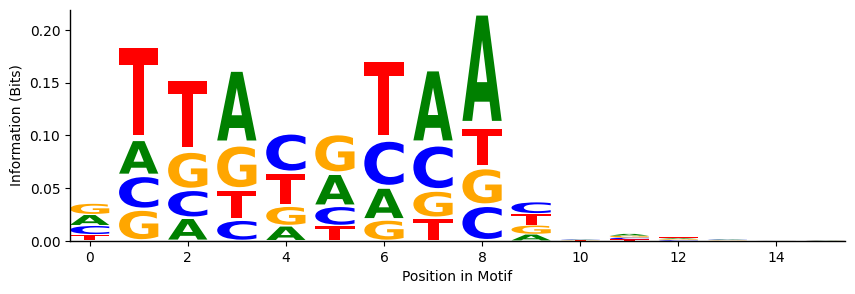

In [104]:
fig, ax = plt.subplots(figsize=(10, 3))
    
logo = logomaker.Logo(info_df,
                      ax=ax,
                      color_scheme='classic',
                      vpad=.1,
                      width=.8)

logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
ax.set_ylabel("Information (Bits)")
ax.set_xlabel("Position in Motif")
#ax.set_ylim([0, 2])

plt.show()